In [ ]:
setwd('../Thyroid_code')
library(Seurat)
library(ggsci)
library(dplyr)
library(ggplot2)
library(reshape2)
library(cowplot)
library(ggpubr)
library(glue)
library(vegan)
library(ggrepel)
source('Tumor_analysis_functions.R')
vlnplot_modify <- function(obj, marker_genes, group_by, group_order=NULL){
  ######
  # @author        : xinwang 
  # @version       : 1.0.0
  # @desc          : vlnplot moodify
  # @param obj     : Seurat object. 
  # @param marker_genes     : a vector of genes.
  # @param group_by     : column name in seurat, such as 'seurat_cluster'.
  # @return        : ggplot object. 
  ######
  gene_exp = FetchData(obj, vars=marker_genes)
  gene_exp$group = obj@meta.data[rownames(gene_exp), group_by]
  
  gene_exp_mean = gene_exp %>%
    group_by(group) %>%
    summarise_all(list(mean)) %>% as.data.frame()
  gene_exp_mean = melt(gene_exp_mean)
  colnames(gene_exp_mean) = c('group1', 'gene', 'mean_exp')
  plot_data = melt(gene_exp)
  colnames(plot_data) = c('group2', 'gene', 'all_exp')
  
  gene_exp_mean$merge_id = paste0(gene_exp_mean$group1, gene_exp_mean$gene)
  plot_data$merge_id = paste0(plot_data$group2, plot_data$gene)
  plot_data = merge(plot_data, gene_exp_mean, by='merge_id')
  
  if(!is.null(group_order)){
    plot_data$group1 = factor(plot_data$group1,levels=group_order)
  }
  res=ggplot(plot_data, aes(x=group1, y=all_exp, fill=mean_exp)) +
    geom_violin(scale = "width", adjust = 1, trim = TRUE, linewidth=0.1)+
    scale_fill_gradient(low = "#F2E80D", high = "#E65224") +
    scale_y_continuous(expand = c(0, 0), position="right", labels = function(x)
      c(rep(x = "", times = length(x)-2), x[length(x) - 1], "")) +
    facet_grid(rows = vars(gene.x), scales = "free", switch = "y") +
    theme_cowplot(font_size = 12) +
    theme(panel.spacing = unit(0, "lines"),
          panel.background = element_rect(fill = NA, color = "black"),
          strip.background = element_blank(),
          strip.text = element_text(face = "bold"),
          strip.text.y.left = element_text(angle = 0),
          axis.text.x = element_text(angle=60, vjust=1,hjust=1))
  return(res)
}

In [ ]:
# Set global theme including font
# theme_set(
#   theme_minimal(base_family = "Arial") +  # Can also use theme_classic() etc
#     theme(
#       text = element_text(family = "Arial"),  # Set all text
#       plot.title = element_text(family = "Arial", face = "bold", size = 14),  # Title
#       axis.title = element_text(family = "Arial", size = 12),  # Axis title
#       axis.text = element_text(family = "Arial", size = 10),  # Axis text
#       legend.text = element_text(family = "Arial"),  # Legend text
#       legend.title = element_text(family = "Arial")  # Legend title
#     )
# )
set.seed(1123)
MyDimPlot <-function(obj, ...){
  umap = as.data.frame(obj@reductions$umap@cell.embeddings)
  DimPlot(obj, seed = 1, ...)+
    scale_color_manual(values = Celltype_colors)+
    theme(
      axis.line = element_blank(),
      axis.ticks = element_blank(), # Hide ticks
      axis.text = element_blank(), # Hide tick text
      axis.title = element_blank(),
      legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    )+
    labs('title'='')+
    geom_segment(aes(x=min(umap$UMAP_1), y=min(umap$UMAP_2), xend=min(umap$UMAP_1)+2, yend=min(umap$UMAP_2)),
                 colour="black", size=0.5,arrow = arrow(length=unit(0.2,"cm")))+ 
    geom_segment(aes(x = min(umap$UMAP_1), y = min(umap$UMAP_2), xend = min(umap$UMAP_1), yend=min(umap$UMAP_2)+2),
                 colour = "black", size=0.5,arrow = arrow(length = unit(0.2,"cm"))) +
    annotate("text", x = min(umap$UMAP_1)+4, y = min(umap$UMAP_2), label = "UMAP1",
             color="black",size = 4) + 
    annotate("text", x = min(umap$UMAP_1), y = min(umap$UMAP_2)+4, label = "UMAP2",
             color="black",size = 4, angle=90) 
}
my_level_prop <- function(obj, 
                          levels='orig.ident', 
                          group_by_name='seurat_clusters',
                          mutate_meta=NULL,
                          obj_is_meta=FALSE){
  # Calculate proportion of groups in levels
  if(!obj_is_meta){
    tmp_meta = obj@meta.data
  }else{
    tmp_meta = obj
  }
  tmp_res = tmp_meta %>%
    group_by_at(vars(one_of(c(levels, group_by_name))))%>%
    summarise(group_num=n())
  colnames(tmp_res) = c('levels', 'groups', 'group_num')
  tmp_res = tmp_res %>% spread(groups, group_num, fill = 0) 
  tmp_res[,2:ncol(tmp_res)] = tmp_res[,2:ncol(tmp_res)] / rowSums(tmp_res[,2:ncol(tmp_res)])
  tmp_res = tidyr::gather(tmp_res, key, value, -levels) %>% as.data.frame()
  colnames(tmp_res) = c(levels, group_by_name, 'prop')
  if(!is.null(mutate_meta)){
    tmp_res = tmp_res %>% left_join(tmp_meta[, c(levels, mutate_meta)] %>% distinct())
  }
  return(tmp_res)
}
# Color definitions
source('../color_definition.R')


# Main cluster UMAP

In [ ]:
output_dir='./Figure1/'
# srt = readRDS('../output/clean_rds/All_ann_97_new.rds')
srt_meta = read.table('../all_srt_meta97.txt', sep='\t', header=T)

In [4]:
dim(srt_meta)

[1] 547280     26

In [5]:
table(srt_meta$Cluster)


      Bcell Endothelial  Epithelial  Fibroblast         LEC     Myeloid 
      34098       87691      164648       80040        8267       39944 
      Tcell 
     132592 

# Quality distribution

In [6]:
head(srt_meta)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,patient,Tissue_desc,Sex,Age_at_diagnosis_years,Tumor_metastasis,LN_metastasis,⋯,sample_id,Cluster,sub_cluster,CellType,seurat_clusters,batch,UMAP_1,UMAP_2,TSNE_1,TSNE_2
,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TC047_B_AAACCTGAGGAACTGC-1,TC047_B,1627,1006,0.4967710,PTC32,B,Female,<55,LN metastasis,Central,⋯,TC047_B,Tcell,NKT,Tcell,0,old,-0.9074704,-14.942422,15.941474,8.595133
TC047_B_AAACCTGGTACTCTCC-1,TC047_B,2018,1299,1.7692308,PTC32,B,Female,<55,LN metastasis,Central,⋯,TC047_B,Tcell,CD4_Tcm,Tcell,5,old,-0.1867673,-8.395889,-5.170951,7.029979
TC047_B_AAACCTGGTCTAGTGT-1,TC047_B,1267,844,1.3245033,PTC32,B,Female,<55,LN metastasis,Central,⋯,TC047_B,Tcell,CD4_Tn,Tcell,1,old,-2.7180208,-10.388069,NA,NA
TC047_B_AAACCTGGTTGTGGAG-1,TC047_B,1772,1187,1.7032721,PTC32,B,Female,<55,LN metastasis,Central,⋯,TC047_B,Tcell,CD4_Tcm,Tcell,5,old,-1.0777423,-11.648377,NA,NA
TC047_B_AAACGGGGTCATACTG-1,TC047_B,1728,1001,0.9489381,PTC32,B,Female,<55,LN metastasis,Central,⋯,TC047_B,Tcell,CD4_Tcm,Tcell,8,old,-3.1985057,-10.820418,NA,NA
TC047_B_AAACGGGGTCCCGACA-1,TC047_B,1838,1182,1.8989899,PTC32,B,Female,<55,LN metastasis,Central,⋯,TC047_B,Tcell,CD8_Teff,Tcell,15,old,-0.4220965,-10.063268,NA,NA


`summarise()` has grouped output by 'orig.ident'. You can override using the `.groups` argument.


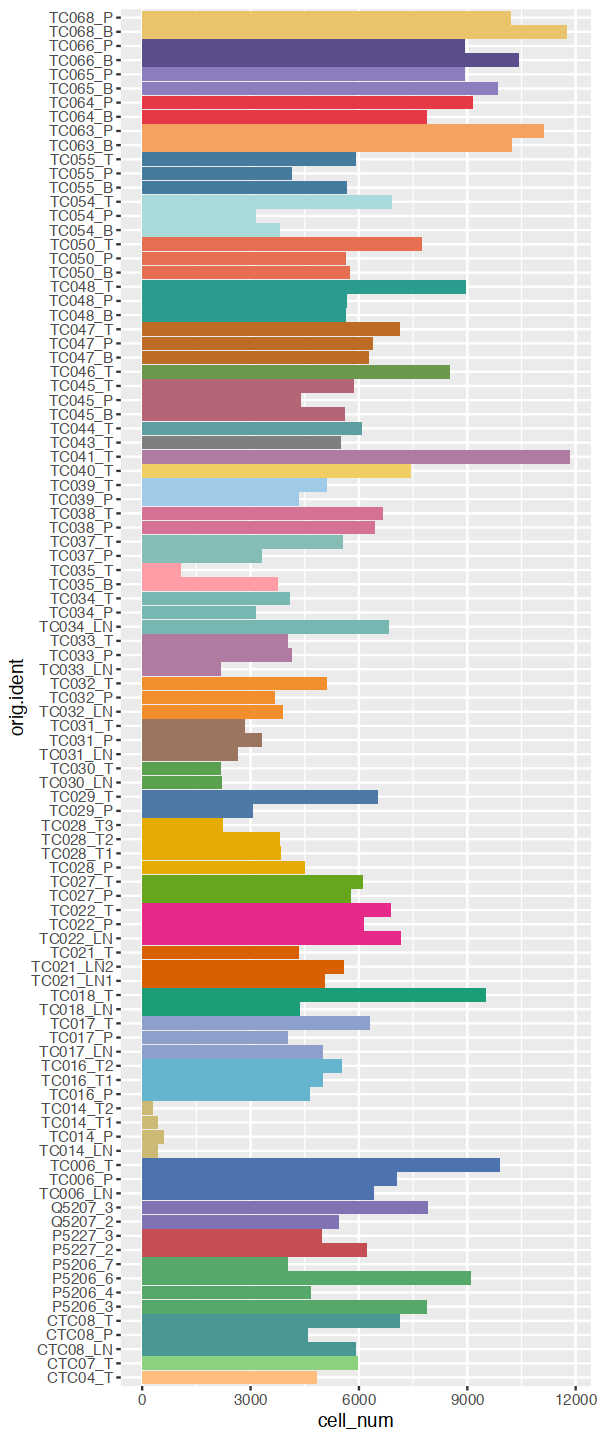

In [7]:
options(repr.plot.width=5, repr.plot.height=12)
a=srt_meta %>%
    group_by(orig.ident, patient) %>%
    summarise(cell_num=n()) %>%
    ggplot(aes(x=cell_num,y=orig.ident, fill=patient))+
    geom_bar(stat='identity')+
    scale_fill_manual(values = all_patient_color)+
    NoLegend()
a

In [11]:
length(unique(srt_meta$orig.ident))

[1] 97

In [27]:
srt_meta_uniq = srt_meta[, c('patient', 'orig.ident')] %>% unique()
srt_meta_uniq = srt_meta_uniq %>%
    mutate(patient=factor(patient, levels=names(all_patient_color))) %>%
    arrange(patient)
sample_order = rev(srt_meta_uniq$orig.ident)

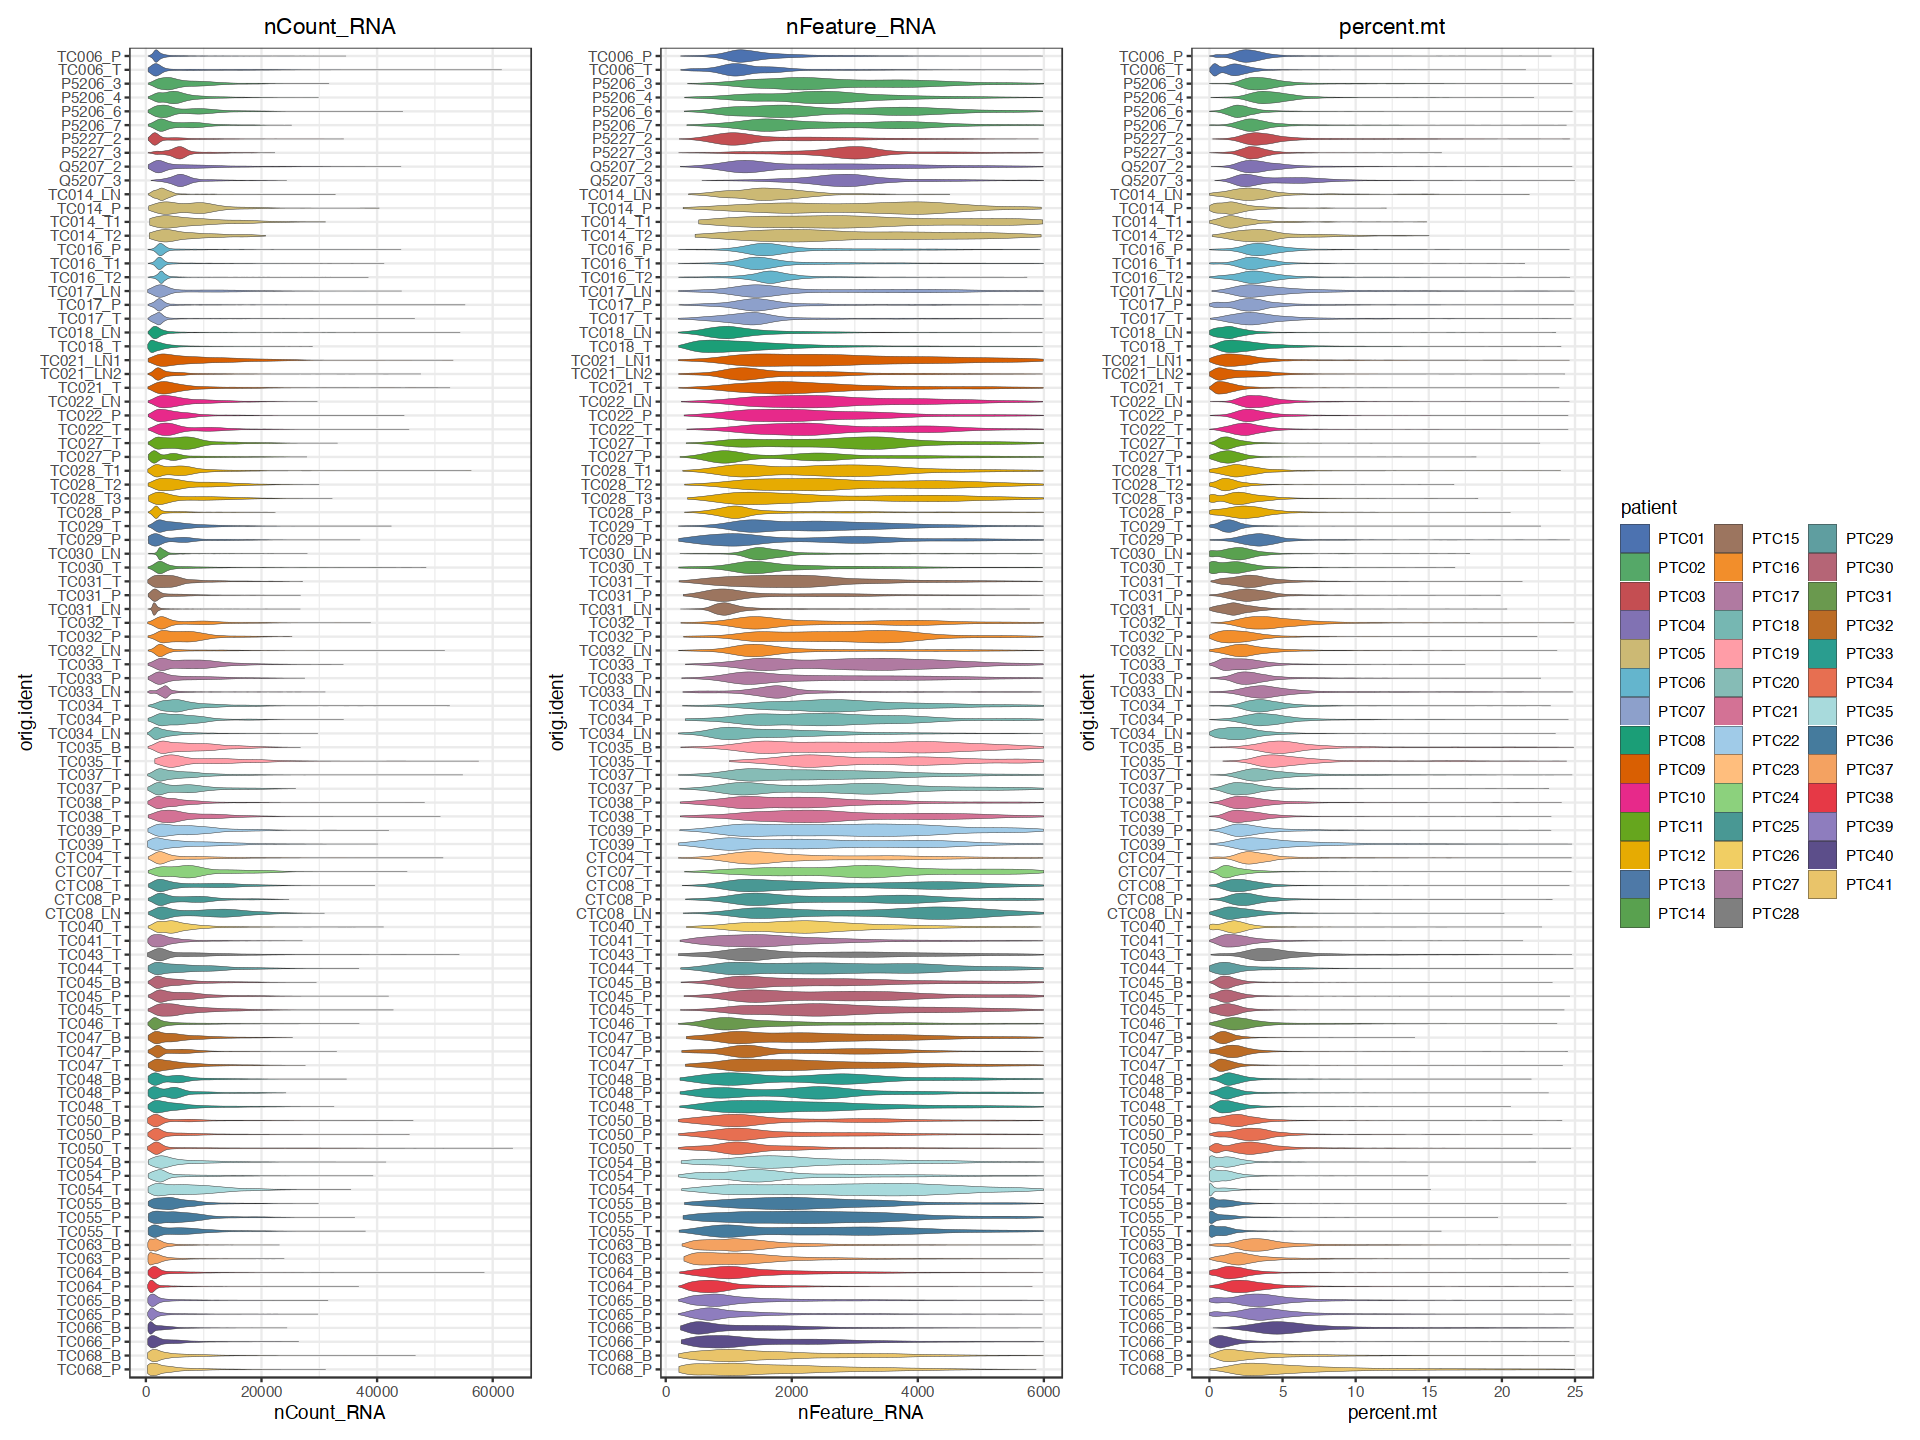

In [28]:
options(repr.plot.width=12, repr.plot.height=5)
b=srt_meta %>%
    filter(Tissue_desc!='LN_N') %>%
    mutate(orig.ident=factor(orig.ident, sample_order)) %>%
    ggplot(aes(y=orig.ident, x=nCount_RNA, fill=patient)) +
    geom_violin(scale = 'width', size=0.1)+
    scale_fill_manual(values = all_patient_color)+
    labs(title='nCount_RNA')+
    theme_bw()+
    theme(plot.title=element_text(hjust=0.5))+
    NoLegend()
c=srt_meta %>%
    filter(Tissue_desc!='LN_N') %>%
    mutate(orig.ident=factor(orig.ident, sample_order)) %>%
    ggplot(aes(y=orig.ident, x=nFeature_RNA, fill=patient)) +
    geom_violin(scale = 'width', size=0.1)+
    scale_fill_manual(values = all_patient_color)+
    labs(title='nFeature_RNA')+
    theme_bw()+
    theme(plot.title=element_text(hjust=0.5))+
    NoLegend()
d=srt_meta %>%
    filter(Tissue_desc!='LN_N') %>%
    mutate(orig.ident=factor(orig.ident, sample_order)) %>%
    ggplot(aes(y=orig.ident, x=percent.mt, fill=patient)) +
    geom_violin(scale = 'width', size=0.1)+
    scale_fill_manual(values = all_patient_color)+
    labs(title='percent.mt')+
    theme_bw()+
    theme(plot.title=element_text(hjust=0.5))
options(repr.plot.width=16, repr.plot.height=12)
b+c+d

In [29]:
ggsave(glue('{output_dir}/sample_quality_distribution.pdf'), b+c+d,
       width=240, height=240, units='mm', dpi = 450, bg = 'transparent')

## Tissue coloring

In [42]:
all_cells=srt_meta %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=Tissue_desc),shape=21,size=0.2, stroke=NA)+
  scale_fill_manual(values = tissue_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )+
  guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')

In [43]:
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/main_cluster_cell_subtypetissue_coloring(legend).pdf'), plot = legend, width = 5, height = 3)

all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/main_cluster_cell_subtypetissue_coloring(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')


In [31]:
all_cells=srt_meta%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=Tissue_desc),shape=20,size=0.05, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = tissue_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/main_cluster_cell_subtypetissue_coloring(raster).pdf'), all_cells,
       width=60, height=60, units='mm', dpi = 900, bg = 'transparent')

In [48]:
table(srt_meta$CellType)


      Bcell Endothelial  Epithelial  Fibroblast         LEC        Mast 
      24217       61393      138513       70373        5589        1188 
    Myeloid         pDC      Plasma       Tcell 
      28777         414        7870      110588 

In [49]:
all_cells=srt_meta %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=Cluster),shape=21,size=0.2, stroke=NA)+
  scale_fill_manual(values = Celltype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )+
  guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')

ggsave(glue('{output_dir}/main_cluster_cell_subtypecluster_coloring.pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/main_cluster_cell_subtypecluster_coloring(legend).pdf'), plot = legend, width = 5, height = 3)

all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/main_cluster_cell_subtypecluster_coloring(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')


In [32]:
all_cells=srt_meta%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=Cluster),shape=20,size=0.05, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = Celltype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/main_cluster_cell_subtypecluster_coloring(raster).pdf'), all_cells,
       width=60, height=60, units='mm', dpi = 900, bg = 'transparent')

## Color by subcluster

In [59]:
all_cells=srt_meta %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )+
  guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/main_cluster_cell_subtypesubcluster_coloring.pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/main_cluster_cell_subtypesubcluster_coloring(legend).pdf'),
       plot = legend, width = 5, height = 5)

all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/main_cluster_cell_subtypesubcluster_coloring(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [9]:
srt_meta_label = srt_meta %>% group_by(sub_cluster) %>% summarise(UMAP_1 = mean(UMAP_1), UMAP_2 = mean(UMAP_2))

In [ ]:
#tmp_x = sample(rownames(srt_meta), 10000)

In [24]:

all_cells=srt_meta%>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=sub_cluster),shape=20,size=0.05, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = all_subtype_colors)+
  geom_text_repel(aes(label=sub_cluster),size=2, data=srt_meta_label, max.overlaps = Inf)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/main_cluster_cell_subtypesubcluster_coloring(label).pdf'), all_cells,
       width=60, height=60, units='mm', dpi = 900, bg = 'transparent')


In [109]:
library(mascarade)
library(ggplot2)
library(data.table)

In [110]:
maskTable <- generateMask(dims=srt_meta[,c('UMAP_1','UMAP_2')], 
                          clusters=srt_meta$sub_cluster)

Warning message in FUN(X[[i]], ...):
“Mask is empty for cluster ISG+T”
Warning message in FUN(X[[i]], ...):
“Mask is empty for cluster Proliferating_T”
Warning message in FUN(X[[i]], ...):
“Mask is empty for cluster CD8_Tex”
Warning message in FUN(X[[i]], ...):
“Mask is empty for cluster Switched_memory_B”
Warning message in FUN(X[[i]], ...):
“Mask is empty for cluster Macro_ISG15”
Warning message in FUN(X[[i]], ...):
“Mask is empty for cluster Myeloid_MKI67”
Warning message in FUN(X[[i]], ...):
“Mask is empty for cluster proliferative_EC”
Warning message in FUN(X[[i]], ...):
“Mask is empty for cluster C3_MT1G”
Warning message in FUN(X[[i]], ...):
“Mask is empty for cluster Proliferative_CAF”


In [112]:
fancyMask <- list(
    geom_mark_shape(data=maskTable, fill = NA, aes(group=group, color=cluster, label=cluster),
                   linewidth=1, expand=unit(-1, "pt"),
                   con.cap=0, con.type = "straight",
                   label.fontsize = 10, label.buffer = unit(0, "cm"),
                   label.fontface = "plain",
                   label.minwidth = 0,
                   label.margin = margin(2, 2, 2, 2, "pt"),
                   label.lineheight = 0,
                   con.colour = "inherit",
                   show.legend = FALSE),
    # expanding to give a bit more space for labels
    scale_x_continuous(expand = expansion(mult = 0.1)),
    scale_y_continuous(expand = expansion(mult = 0.1))
)

In [113]:

all_cells=srt_meta%>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=sub_cluster),shape=20,size=0.05, stroke=NA,raster.dpi = 1500)+
  #geom_path(data=maskTable, aes(group=group)) +
fancyMask+
  scale_color_manual(values = all_subtype_colors)+
  #geom_text_repel(aes(label=sub_cluster),size=2, data=srt_meta_label, max.overlaps = Inf)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/main_cluster_cell_subtypesubcluster_coloring2(label).pdf'), all_cells,
       width=60, height=60, units='mm', dpi = 900, bg = 'transparent')


Warning message in mapply(FUN = f, ..., SIMPLIFY = FALSE):
“longer argument not a multiple of length of shorter”


## Color by patient

In [35]:

all_cells=srt_meta %>%
    filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=patient),shape=21,size=0.2, stroke=NA)+
  scale_fill_manual(values = all_patient_color)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )+
  guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')

legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/main_cluster_cell_subtypepatient_coloring(legend).pdf'),
       plot = legend, width = 5, height = 5)

all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/main_cluster_cell_subtypepatient_coloring(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')


In [36]:
all_cells=srt_meta%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=patient),shape=20,size=0.05, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = all_patient_color)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/main_cluster_cell_subtypepatient_coloring(raster).pdf'), all_cells,
       width=60, height=60, units='mm', dpi = 900, bg = 'transparent')

## Color by metastasis

In [61]:
all_cells=srt_meta %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=Tumor_metastasis),shape=21,size=0.2, stroke=NA)+
  scale_fill_manual(values = tissue_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )+
  guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')

ggsave(glue('{output_dir}/main_cluster_cell_subtypemetastasis_coloring.pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/main_cluster_cell_subtypemetastasis_coloring(legend).pdf'),
       plot = legend, width = 5, height = 5)

all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/main_cluster_cell_subtypemetastasis_coloring(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')


# Main cluster markers

In [37]:
srt = readRDS('../output/clean_rds/All_ann_97.rds')

In [38]:
srt[['SCT']] = NULL
srt[['integrated']] = NULL
srt[['prediction.score.ref_data']] = NULL

In [ ]:
srt_meta = read.table('../all_srt_meta97.txt', sep='\t', header=T)

In [48]:
srt@reductions$umap@cell.embeddings[, 1] = srt_meta[colnames(srt), 'UMAP_1']
srt@reductions$umap@cell.embeddings[, 2] = srt_meta[colnames(srt), 'UMAP_2']

In [54]:
marker_list = c('PTPRC', 
                'CD3D', 'CD3E',
                "CD79A","MS4A1",
                'CD68', 'LYZ',
                "ACTA2","COL1A1",'COL1A2', 
                "PECAM1","VWF","CD34",
                "EPCAM", "TG", "TPO")
x = FeaturePlot(srt, marker_list, cols = c('gray', 'red'))
for(i in 1:length(marker_list)){
  x[[i]] = x[[i]]+
    theme(axis.line = element_blank(),
          axis.ticks= element_blank(),
          axis.text = element_blank(),
          axis.title = element_blank(),
          legend.position = 'none')
}
ggsave(glue('{output_dir}/main_cluster_markers.pdf'), x,width = 12, height = 12)


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

In [51]:
x = vlnplot_modify(srt, marker_list,group_by = 'Cluster',
                   group_order=c('Tcell', 'Bcell', 'Myeloid', 'Fibroblast', 'LEC', 'Endothelial','Epithelial'))
ggsave(glue('{output_dir}/main_cluster_markers_vlnplot.pdf'), x,width = 4, height = 5)

Using group as id variables

Using group as id variables



## Tcell

In [ ]:
srt_sub = readRDS('../output/clean_rds/Tcell_ann_97.rds')
umap = as.data.frame(srt_sub@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt_sub$sub_cluster

In [70]:

all_cells=umap %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/T_cell_subtypeUMAP(legend).pdf'),
       plot = legend, width = 5, height = 5)
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/T_cell_subtypeUMAP(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [62]:
umap$Tissue_desc = srt_sub$Tissue_desc
a1=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=Tissue_desc),shape=20,size=0.2, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = tissue_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
a2=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=sub_cluster),shape=20,size=0.2, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/T_cell_subtype_UMAP_coloring_raster.pdf'), a1+a2,
       width=120, height=60, units='mm', dpi = 900, bg = 'transparent')

In [68]:
if(file.exists(glue('{output_dir}/Tcell_markers.csv'))){
    tmp_markers = read.table( glue('{output_dir}/Tcell_markers.csv'), header=T)
}else{
    Idents(srt_sub) = srt_sub$sub_cluster
    tmp_markers = FindAllMarkers(srt_sub, max.cells.per.ident = 300)
    write.table(tmp_markers, glue('{output_dir}/Tcell_markers.csv'), sep='\t', row.names=F, quote=F)
}

In [69]:
top_markers = tmp_markers %>% group_by(cluster) %>% top_n(5,avg_log2FC)
x=DotPlot(srt_sub, features = unique(top_markers$gene), cols=c("#A6CEE3", '#D73027'))+
  theme_bw()+
  coord_flip()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust = 1,vjust = 1))
ggsave( glue('{output_dir}/T_cell_subtypemarker.pdf'), x,
       width=120, height=200, units='mm', dpi = 450, bg = 'transparent')

## Bcell

In [71]:
srt_sub = readRDS('../output/clean_rds/Bcell_ann_97.rds')
umap = as.data.frame(srt_sub@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt_sub$sub_cluster
all_cells=umap %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/B_cell_subtypeUMAP(legend).pdf'),
       plot = legend, width = 5, height = 5)
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/B_cell_subtypeUMAP(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [75]:
umap$Tissue_desc = srt_sub$Tissue_desc
a1=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=Tissue_desc),shape=20,size=0.5, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = tissue_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
a2=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=sub_cluster),shape=20,size=0.5, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/B_cell_subtype_UMAP_coloring_raster.pdf'), a1/a2,
       width=60, height=120, units='mm', dpi = 900, bg = 'transparent')

In [73]:
if(file.exists(glue('{output_dir}/Bcell_markers.csv'))){
    tmp_markers = read.table( glue('{output_dir}/Bcell_markers.csv'), header=T)
}else{
    Idents(srt_sub) = srt_sub$sub_cluster
    tmp_markers = FindAllMarkers(srt_sub, max.cells.per.ident = 300)
    write.table(tmp_markers, glue('{output_dir}/Bcell_markers.csv'), sep='\t', row.names=F, quote=F)
}

Calculating cluster Memory_B

Calculating cluster Naive_B

Calculating cluster Plasma

Calculating cluster Centroblast

Calculating cluster Centrocyte

Calculating cluster Switched_memory_B



In [74]:
top_markers = tmp_markers %>% group_by(cluster) %>% top_n(5,avg_log2FC)
x=DotPlot(srt_sub, features = unique(top_markers$gene), cols=c("#A6CEE3", '#D73027'))+
  theme_bw()+
  coord_flip()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust = 1,vjust = 1))
ggsave( glue('{output_dir}/B_cell_subtypemarker.pdf'), x,
       width=120, height=200, units='mm', dpi = 450, bg = 'transparent')

## Myeloid

In [76]:
srt_sub = readRDS('../output/clean_rds/Myeloid_ann_97.rds')
umap = as.data.frame(srt_sub@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt_sub$sub_cluster
all_cells=umap %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/Myeloid_cell_subtypeUMAP(legend).pdf'),
       plot = legend, width = 5, height = 5)
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/Myeloid_cell_subtypeUMAP(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [77]:
umap$Tissue_desc = srt_sub$Tissue_desc
a1=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=Tissue_desc),shape=20,size=0.5, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = tissue_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
a2=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=sub_cluster),shape=20,size=0.5, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/Myeloid_cell_subtype_UMAP_coloring_raster.pdf'), a1/a2,
       width=60, height=120, units='mm', dpi = 900, bg = 'transparent')

In [78]:
tmp_cell='Myeloid'
if(file.exists(glue('{output_dir}/{tmp_cell}_markers.csv'))){
    tmp_markers = read.table( glue('{output_dir}/{tmp_cell}_markers.csv'), header=T)
}else{
    Idents(srt_sub) = srt_sub$sub_cluster
    tmp_markers = FindAllMarkers(srt_sub, max.cells.per.ident = 300)
    write.table(tmp_markers, glue('{output_dir}/{tmp_cell}_markers.csv'), sep='\t', row.names=F, quote=F)
}
top_markers = tmp_markers %>% group_by(cluster) %>% top_n(5,avg_log2FC)
x=DotPlot(srt_sub, features = unique(top_markers$gene), cols=c("#A6CEE3", '#D73027'))+
  theme_bw()+
  coord_flip()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust = 1,vjust = 1))
ggsave( glue('{output_dir}/{tmp_cell}cell_subtype_markers.pdf'), x,
       width=120, height=200, units='mm', dpi = 450, bg = 'transparent')

Calculating cluster Macro_FOLR2

Calculating cluster Mono

Calculating cluster Macro_IL1B

Calculating cluster Macro_ISG15

Calculating cluster cDC2

Calculating cluster Myeloid_MKI67

Calculating cluster Macro_SPP1

Calculating cluster Mast

Calculating cluster pDC

Calculating cluster cDC1

Calculating cluster cDC3



## Endothelial


In [79]:
srt_sub = readRDS('../output/clean_rds/Endothelial_ann_97.rds')
umap = as.data.frame(srt_sub@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt_sub$sub_cluster
all_cells=umap %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/Endothelial_cell_subtypeUMAP(legend).pdf'),
       plot = legend, width = 5, height = 5)
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/Endothelial_cell_subtypeUMAP(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [80]:
umap$Tissue_desc = srt_sub$Tissue_desc
a1=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=Tissue_desc),shape=20,size=0.5, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = tissue_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
a2=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=sub_cluster),shape=20,size=0.5, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/Endothelial_cell_subtype_UMAP_coloring_raster.pdf'), a1/a2,
       width=60, height=120, units='mm', dpi = 900, bg = 'transparent')

In [81]:
tmp_cell='Endothelial'
if(file.exists(glue('{output_dir}/{tmp_cell}_markers.csv'))){
    tmp_markers = read.table( glue('{output_dir}/{tmp_cell}_markers.csv'), header=T)
}else{
    Idents(srt_sub) = srt_sub$sub_cluster
    tmp_markers = FindAllMarkers(srt_sub, max.cells.per.ident = 300)
    write.table(tmp_markers, glue('{output_dir}/{tmp_cell}_markers.csv'), sep='\t', row.names=F, quote=F)
}
top_markers = tmp_markers %>% group_by(cluster) %>% top_n(5,avg_log2FC)
x=DotPlot(srt_sub, features = unique(top_markers$gene), cols=c("#A6CEE3", '#D73027'))+
  theme_bw()+
  coord_flip()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust = 1,vjust = 1))
ggsave( glue('{output_dir}/{tmp_cell}cell_subtype_markers.pdf'), x,
       width=120, height=200, units='mm', dpi = 450, bg = 'transparent')

Calculating cluster capillary_EC

Calculating cluster venous_EC

Calculating cluster arterial_EC

Calculating cluster proliferative_EC

Warning message:
“Scaling data with a low number of groups may produce misleading results”


## Epithelial

In [93]:
srt_sub = readRDS('../output/clean_rds/97_sample_epithelial_mapping.rds')
umap = as.data.frame(srt_sub@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt_sub$sub_cluster
all_cells=umap %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/Epithelial_cell_subtypeUMAP(legend).pdf'),
       plot = legend, width = 5, height = 5)
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/Epithelial_cell_subtypeUMAP(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [95]:
umap = as.data.frame(srt_sub@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt_sub$sub_cluster
umap$Tissue_desc = srt_sub$Tissue_desc
all_cells=umap %>%
  mutate(Tissue_desc=factor(Tissue_desc, levels = c('P', 'B', 'T', 'LN_M'))) %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=sub_cluster),shape=20,size=1, stroke=NA,raster.dpi = 900)+
  scale_color_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/Epithelial_cell_subtypeUMAP(cellsraster).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [103]:
marker_list = c('ZFP36', 'MAFF', 'GADD45A', 'GADD45B', 'ATF3', 'SOCS3',
                'TPO',
                'HAPA1A', 'DNAJB1', 'HSPA1B', 'HSPA6', 'DUSP1', 'FOS', 'JUN',
                'MT1H', 'MT1G', 'MT1F', 'MT1X', 'MT2A', 'MT1E', 'MT1M',
                'KRT19', 'AGER', 'SPARC',
                'CD74', 'HLA-DRA', 'HLA-DRB1',' HLA-DPA1', 'IFI6', 'ISG15'
)
DefaultAssay(srt_sub)='RNA'
a=DotPlot(srt_sub, features = marker_list, group.by = 'sub_cluster',dot.scale=3)+
  scale_color_gradientn(colours = c('#2C7BB6','#ABD9E9','#FFFFFF','#FDAE61','#D7191C'))+
  theme(axis.text.x = element_text(angle = 45, hjust = 1,vjust = 1))+
  coord_flip()+
  theme(axis.text = element_text(size=7),
        axis.title = element_blank(),
        axis.line = element_line(linewidth = 0.2),
        axis.ticks = element_line(linewidth = 0.2),
        legend.title = element_text(size=10),
        legend.text = element_text(size=8),
        legend.key.size = unit(0.6, 'cm'), #change legend key size
        #legend.key.height = unit(1, 'cm'), #change legend key height
        legend.key.width = unit(0.4, 'cm')
        )
ggsave( glue('{output_dir}/Epithelial_cell_subtypemarker.pdf'), a,
       width=90, height=120, units='mm', dpi = 450, bg = 'transparent')

Warning message:
“The following requested variables were not found: HAPA1A,  HLA-DPA1”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [23]:
umap = as.data.frame(srt_sub@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt_sub$sub_cluster
umap$Tissue_desc = srt_sub$Tissue_desc
all_cells=umap %>%
  mutate(Tissue_desc=factor(Tissue_desc, levels = c('P', 'B', 'T', 'LN_M'))) %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=sub_cluster),shape=20,size=1, stroke=NA,raster.dpi = 900)+
  scale_color_manual(values = all_subtype_colors)+
  facet_wrap(~Tissue_desc, ncol=2) +
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/Epithelial_cell_subtype_UMAP_split_legend.pdf'),
       plot = legend, width = 5, height = 5)
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/Epithelial_cell_subtype_UMAP_split_cells.pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [92]:
srt_sub = readRDS('../output/clean_rds/Epithelial_raw_97.rds')
umap = as.data.frame(srt_sub@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt_sub$sub_cluster
all_cells=umap %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/Epithelial_cell_subtypeUMAP_raw(legend).pdf'),
       plot = legend, width = 5, height = 5)
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/Epithelial_cell_subtypeUMAP_raw(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [91]:
umap$Tissue_desc = srt_sub$Tissue_desc
umap$patient = srt_sub$patient

a1=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=Tissue_desc),shape=20,size=0.2, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = tissue_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
a2=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=patient),shape=20,size=0.2, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = all_patient_color)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/Epithelial_cell_subtype_UMAP_coloring_raw_raster.pdf'), a1/a2,
       width=60, height=120, units='mm', dpi = 900, bg = 'transparent')

In [ ]:
#### Cluster similarity with NMF module #### 
DefaultAssay(srt) = 'RNA'

In [104]:
tmp_cell='Epithelial'
if(file.exists(glue('{output_dir}/{tmp_cell}_markers.csv'))){
    tmp_markers = read.table( glue('{output_dir}/{tmp_cell}_markers.csv'), header=T)
}else{
    Idents(srt_sub) = srt_sub$sub_cluster
    tmp_markers = FindAllMarkers(srt_sub, max.cells.per.ident = 300)
    write.table(tmp_markers, glue('{output_dir}/{tmp_cell}_markers.csv'), sep='\t', row.names=F, quote=F)
}

Calculating cluster C1_TPO

Calculating cluster C2_JUN

Calculating cluster C4_SPARC

Calculating cluster C0_MAFF

Calculating cluster C5_HLA-DRA

Calculating cluster C3_MT1G



Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




pdf 
  2

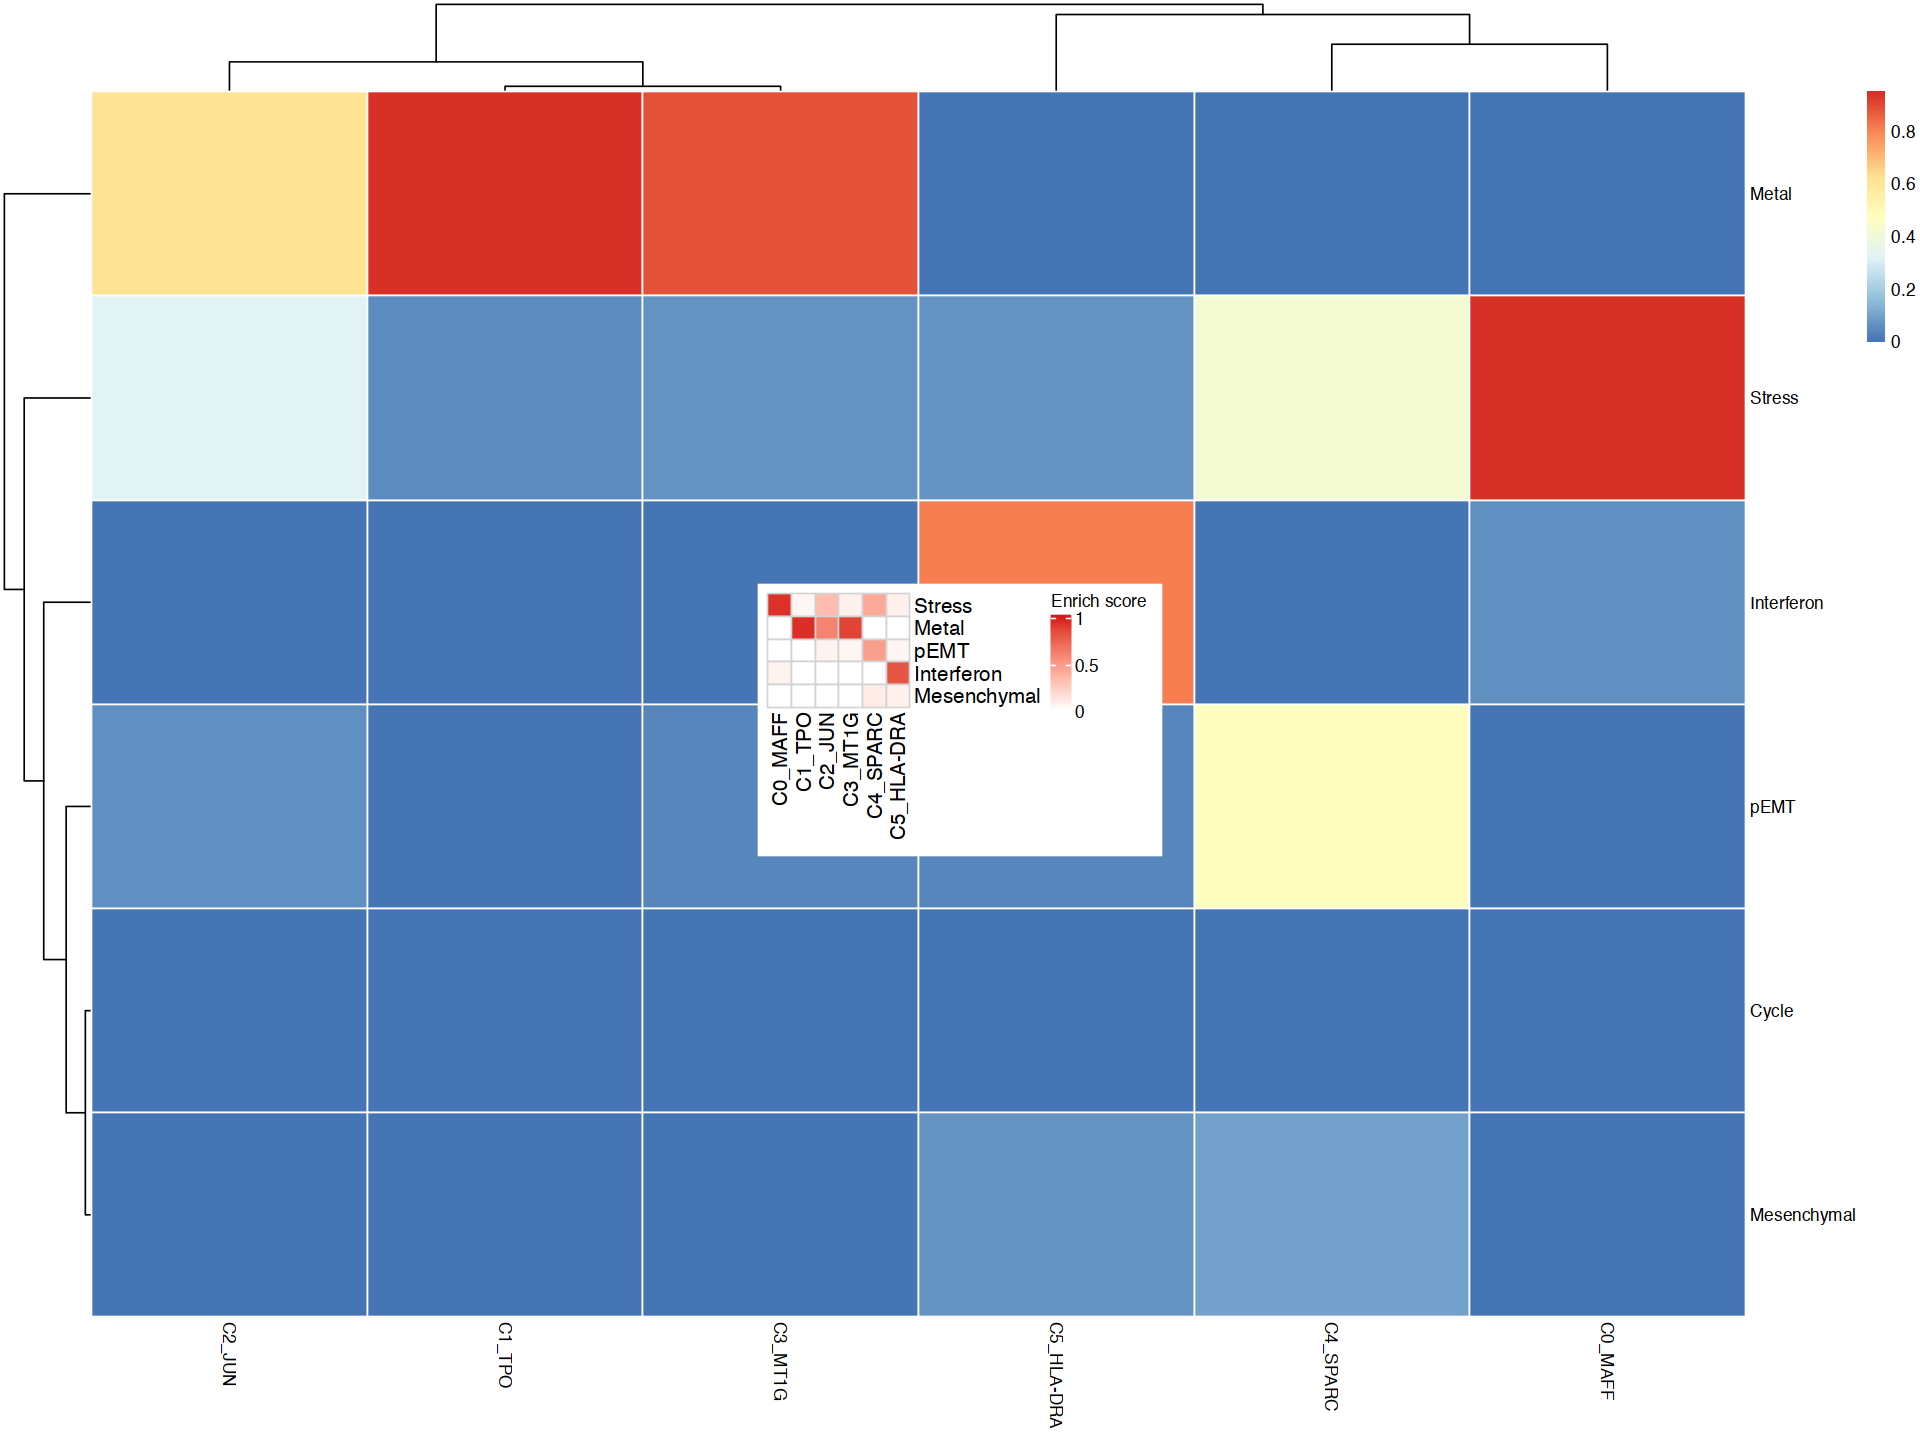

In [106]:
nmf_module = read.csv('../NMF_module.csv')
nmf_module_list = list()
for(i in colnames(nmf_module)){
  nmf_module_list[[i]] = setdiff(na.omit(nmf_module[, i]), "")
}
res = enrich_with_marker(tmp_markers %>% group_by(cluster) %>% top_n(n = 50, wt = avg_log2FC), 
                         nmf_module_list, scale = F)
library(ComplexHeatmap)
ht=Heatmap(res[c('Stress', 'Metal', 'pEMT', 'Interferon','Mesenchymal'),
            c( 'C0_MAFF' , 'C1_TPO','C2_JUN',    'C3_MT1G', 'C4_SPARC', 'C5_HLA-DRA')],
        name='Enrich score',
        cluster_rows = F,
        cluster_columns = F,
        show_row_dend = F,
        show_column_dend = F,
        col=circlize::colorRamp2(c(0,  1), c('#FFFFFF','#D7191C')),
        rect_gp = gpar(col='#D3D3D3'),
        width = ncol(res)*unit(5, "mm"'), # Width
        height = nrow(res)*unit(4, '"mm"'), # Height
)
ht
pdf(glue('{output_dir}/{tmp_cell}enrichment_heatmap.pdf'),width = 4,height = 3)
draw(ht, padding = unit(c(20, 10, 10, 10), '"mm"))
dev.off()

## Fibroblast

In [83]:
srt_sub = readRDS('../output/clean_rds/Fibroblast_ann_97.rds')
umap = as.data.frame(srt_sub@reductions$umap@cell.embeddings)
colnames(umap) = c('UMAP_1', 'UMAP_2')
umap$sub_cluster = srt_sub$sub_cluster
all_cells=umap %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/Fibroblast_cell_subtypeUMAP(legend).pdf'),
       plot = legend, width = 5, height = 5)
all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/Fibroblast_cell_subtypeUMAP(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

In [84]:
umap$Tissue_desc = srt_sub$Tissue_desc
a1=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=Tissue_desc),shape=20,size=0.5, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = tissue_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
a2=umap%>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=UMAP_1, y=UMAP_2))+
  #geom_point(aes(fill=sub_cluster),shape=21,size=0.2, stroke=NA)+
  ggrastr::geom_point_rast(aes(color=sub_cluster),shape=20,size=0.5, stroke=NA,raster.dpi = 1500)+
  scale_color_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
    legend.position = "none",
  )+
  #guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')
ggsave(glue('{output_dir}/Fibroblast_cell_subtypeUMAPcoloring(raster).pdf'), a1/a2,
       width=60, height=120, units='mm', dpi = 900, bg = 'transparent')

In [85]:
tmp_cell='Fibroblast'
if(file.exists(glue('{output_dir}/{tmp_cell}_markers.csv'))){
    tmp_markers = read.table( glue('{output_dir}/{tmp_cell}_markers.csv'), header=T)
}else{
    Idents(srt_sub) = srt_sub$sub_cluster
    tmp_markers = FindAllMarkers(srt_sub, max.cells.per.ident = 300)
    write.table(tmp_markers, glue('{output_dir}/{tmp_cell}_markers.csv'), sep='\t', row.names=F, quote=F)
}
top_markers = tmp_markers %>% group_by(cluster) %>% top_n(5,avg_log2FC)
x=DotPlot(srt_sub, features = unique(top_markers$gene), cols=c("#A6CEE3", '#D73027'))+
  theme_bw()+
  coord_flip()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 60, hjust = 1,vjust = 1))
ggsave( glue('{output_dir}/{tmp_cell}cell_subtype_markers.pdf'), x,
       width=120, height=200, units='mm', dpi = 450, bg = 'transparent')

Calculating cluster vCAF

Calculating cluster iCAF

Calculating cluster mCAF

Calculating cluster Proliferative_CAF

Warning message:
“Scaling data with a low number of groups may produce misleading results”


# Main cluster t-SNE

In [62]:
srt_tsne = srt_meta[!is.na(srt_meta$sub_cluster),]

## Subcluster coloring

In [66]:
all_cells=srt_tsne %>%
  ggplot(aes(x=TSNE_1, y=TSNE_2))+
  geom_point(aes(fill=sub_cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = all_subtype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )+
  guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')

ggsave(glue('{output_dir}/main_cluster_cell_subtypesubcluster_coloringtsne.pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/main_cluster_cell_subtypesubcluster_coloringtsne(legend).pdf'),
       plot = legend, width = 5, height = 5)

all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/main_cluster_cell_subtypesubcluster_coloringtsne(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')

Warning message:
“Removed 347280 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 347280 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 347280 rows containing missing values or values outside the scale range
(`geom_point()`).”


## Main cluster coloring

In [67]:
all_cells=srt_tsne %>%
  ggplot(aes(x=TSNE_1, y=TSNE_2))+
  geom_point(aes(fill=Cluster),shape=21,size=0.5, stroke=NA)+
  scale_fill_manual(values = Celltype_colors)+
  theme_classic()+
  theme(
    axis.line = element_blank(),
    axis.ticks = element_blank(), # Hide ticks
    axis.text = element_blank(), # Hide tick text
    axis.title = element_blank(),
    legend.background = element_rect(fill = "white", size = 1, colour = "white"),
  )+
  guides(fill = guide_legend(override.aes = list(size=4, stroke=NA,shape=21)))+ # Legend size
  labs('title'='')

ggsave(glue('{output_dir}/main_cluster_cell_subtypecluster_coloringtsne.pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')
legend <- get_legend(all_cells)
ggsave(glue('{output_dir}/main_cluster_cell_subtypecluster_coloringtsne(legend).pdf'), plot = legend, width = 5, height = 3)

all_cells=all_cells+NoLegend()
ggsave(glue('{output_dir}/main_cluster_cell_subtypecluster_coloringtsne(cells).pdf'), all_cells,
       width=160, height=160, units='mm', dpi = 450, bg = 'transparent')


Warning message:
“Removed 347280 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 347280 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 347280 rows containing missing values or values outside the scale range
(`geom_point()`).”


# Sample cluster proportion

In [ ]:
# srt = readRDS('../output/clean_rds/All_ann_97_new.rds')

`summarise()` has grouped output by 'orig.ident', 'Cluster'. You can override
using the `.groups` argument.
Joining with `by = join_by(orig.ident)`


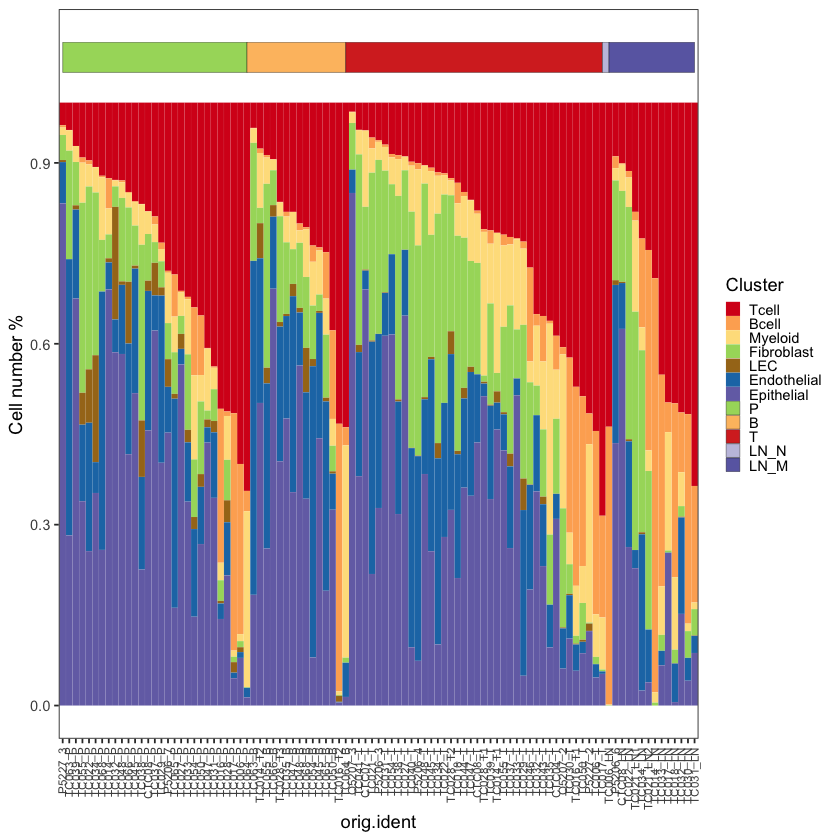

In [69]:
#### Proportion distribution bar plot ####
tmp_data = srt_meta %>%
  group_by(orig.ident, Cluster, Tissue_desc) %>%
  summarise(count=n()) %>%
  left_join(srt_meta %>%
              group_by(orig.ident) %>%
              summarise(all=n())) %>%
  mutate(prop=count/all)
tmp_data$Tissue_desc = factor(tmp_data$Tissue_desc,c('P', 'B', 'T', 'LN_N', 'LN_M'))
tmp_data$Cluster = factor(tmp_data$Cluster,c("Tcell","Bcell","Myeloid","Fibroblast",  "LEC", "Endothelial", "Epithelial"   ))
tmp_data = tmp_data %>% arrange(Tissue_desc, Cluster, prop)
#tmp_data %>% filter(Cluster$)
sample_order = tmp_data$orig.ident %>% unique()
tmp_data$orig.ident = factor(tmp_data$orig.ident, levels = sample_order)

label_bar_data = tmp_data%>%
  filter(Cluster=='Tcell') %>%
  group_by(Tissue_desc) %>%
  summarise(n=n()) %>% as.data.frame()
label_bar_data$xend = cumsum(label_bar_data$n)
label_bar_data$x = c(1,label_bar_data$xend[1:4])
label_bar_data$x_sample = sample_order[label_bar_data$x]
label_bar_data$xend_sample = sample_order[label_bar_data$xend]

a = tmp_data %>% 
  ggplot(aes(x=orig.ident, y=prop,fill=Cluster))+
  geom_bar(stat='identity', position = 'fill', width = 1, color='white', size=0.01)+
  geom_rect(aes(xmin=x_sample,xmax=xend_sample, ymin=1.05, ymax=1.1, fill=Tissue_desc), 
            data=label_bar_data, color='black', size=0.1,inherit.aes = F)+
  scale_fill_manual(values = c(Celltype_colors, tissue_colors)) +
  labs(y='Cell number %')+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(angle = 90,hjust=1,vjust=0.5,size=7),
        legend.key.width = unit(3,'mm'),
        legend.key.height = unit(3,'mm'),
        
        )
a
ggsave(glue('{output_dir}/sample_cluster_proportion_bar_plot.pdf'), a,
       width=220, height=60, units='mm', dpi = 450, bg = 'transparent')

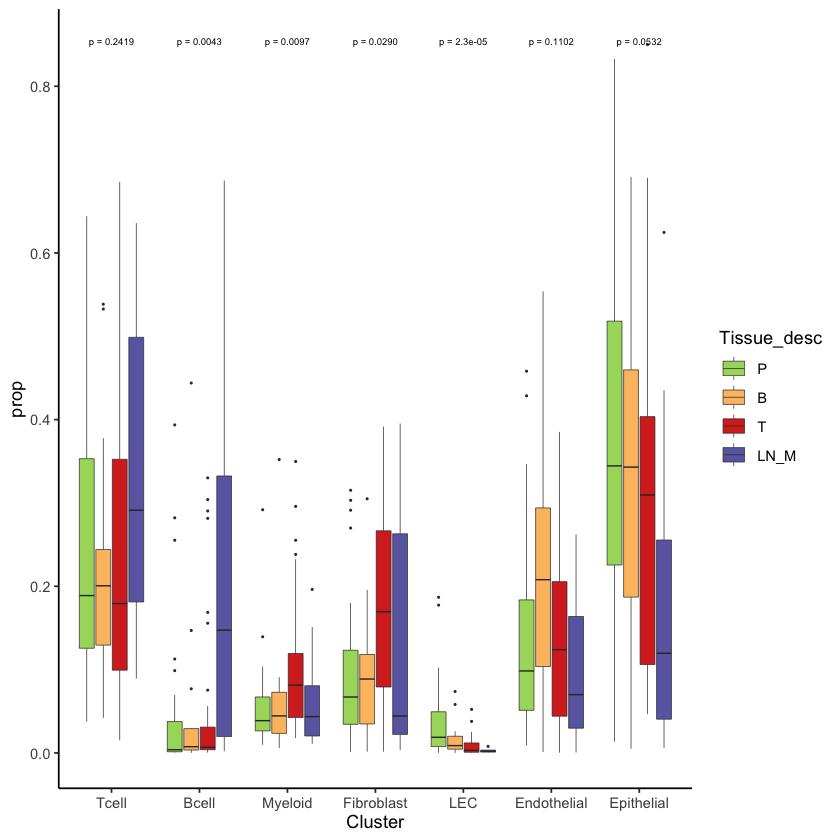

In [70]:
#### Statistical significance ####
a = tmp_data %>% as.data.frame() %>%
  filter(Tissue_desc!='LN_N') %>%
  ggplot(aes(x=Cluster, y=prop, fill=Tissue_desc))+
  geom_boxplot(size=0.2, outlier.size = 0.2)+
  scale_fill_manual(values = tissue_colors)+
  stat_compare_means(label='p.format', size=2)+
  theme_classic()
a
ggsave(glue('{output_dir}/sample_cluster_proportion_box_plot.pdf'), a,
       width=160, height=60, units='mm', dpi = 450, bg = 'transparent')

# Enrichment of subtype proportions across tissues

[1] "Tcell"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Bcell"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Myeloid"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Endothelial"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Epithelial"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "Fibroblast"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


[1] "LEC"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`


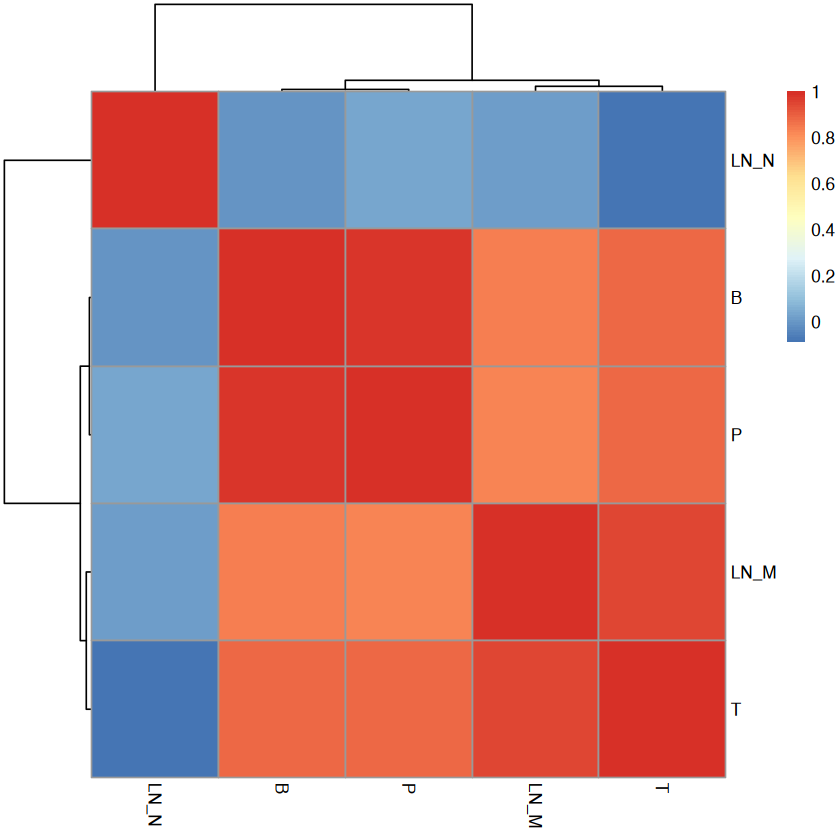

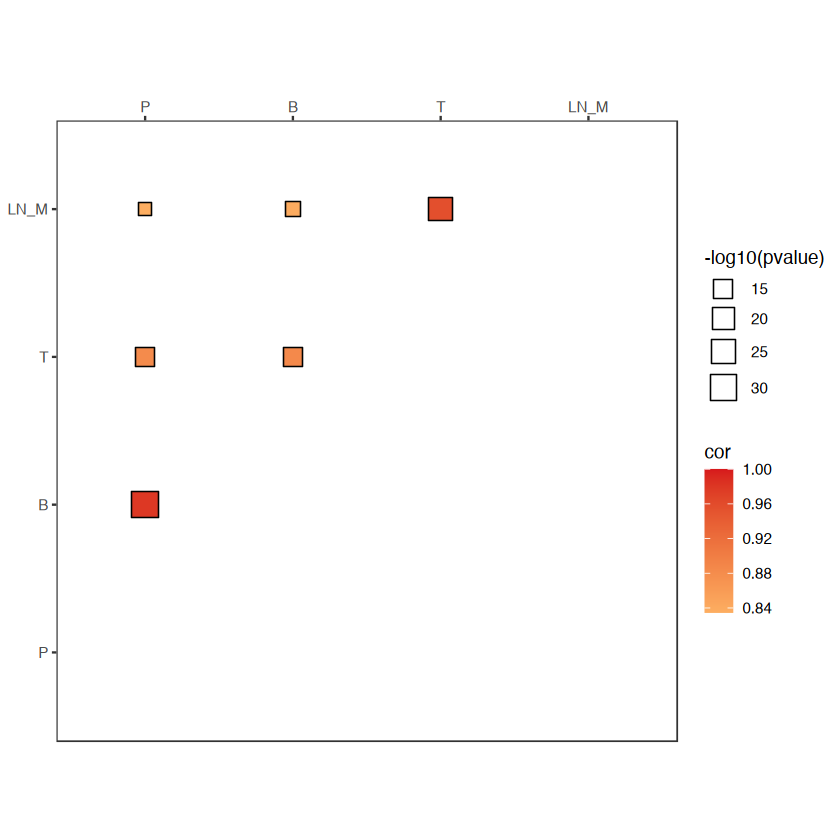

In [4]:
tmp_meta = srt_meta
tmp_meta_unique = tmp_meta[, c('orig.ident', 'Tissue_desc')] %>% unique()
rownames(tmp_meta_unique) = tmp_meta_unique$orig.ident

sample_cell_prop =  c()
for(cl in unique(tmp_meta$Cluster)){
  print(cl)
  tmp_srt = tmp_meta[tmp_meta$Cluster==cl,]
  tmp_prop = my_level_prop(tmp_srt,levels='orig.ident', 
                           group_by_name='sub_cluster',
                           mutate_meta = c('Tissue_desc', 'patient', 'Cluster'),
                           obj_is_meta = TRUE)
  sample_cell_prop = rbind(sample_cell_prop, tmp_prop)
}

df = dcast(sample_cell_prop, Tissue_desc~sub_cluster, value.var = 'prop', fun.aggregate = mean, fill=0)

pair_tissue_data = c()
for(i in 1:nrow(df)){
  tissue1 = unlist(df[i,2:ncol(df)])
  tissue1_str = df[i,1]
  for(j in 1:nrow(df)){
    tissue2 = unlist(df[j,2:ncol(df)])
    tissue2_str = df[j,1]
    ct = cor.test(tissue1,tissue2)
    ct = data.frame('cor'=ct$estimate, 'pvalue'=ct$p.value, 'tissue1'=tissue1_str, 'tissue2'=tissue2_str)
    pair_tissue_data = rbind(pair_tissue_data, ct)
    # tmp_df = cbind(tmp_tissue1,tmp_tissue2)
    # tmp_df = as.data.frame(tmp_df)
    # tmp_df$tissue1=tissue1_str
    # tmp_df$tissue2=tissue2_str
    # pair_tissue_data = rbind(pair_tissue_data, tmp_df)
  }
}
#pair_tissue_data$pvalue[pair_tissue_data$pvalue==0] = min(pair_tissue_data$pvalue[pair_tissue_data$pvalue>0])
cor_mat = reshape2::acast(pair_tissue_data, tissue1~tissue2, value.var = 'cor')
pva_mat = reshape2::acast(pair_tissue_data, tissue1~tissue2, value.var = 'pvalue')

pheatmap::pheatmap(cor_mat)

a=pair_tissue_data %>%
  filter(tissue1!='LN_N') %>%
  filter(tissue2!='LN_N') %>%
  filter(!(tissue1=='B'&tissue2=='P')) %>%
  filter(!(tissue1=='T'&tissue2=='P') )%>%
  filter(!(tissue1=='LN_M'&tissue2=='P')) %>%
  filter(!(tissue1=='LN_M'&tissue2=='T')) %>%
  filter(!(tissue1=='T'&tissue2=='B')) %>%
  filter(!(tissue1=='LN_M'&tissue2=='B')) %>%
  mutate(tissue1=factor(tissue1, c('P', 'B', 'T', 'LN_N', 'LN_M'))) %>%
  mutate(tissue2=factor(tissue2, c('P', 'B', 'T', 'LN_N', 'LN_M'))) %>%
  ggplot(aes(x = tissue1, y = tissue2)) +
  geom_point(aes(size=-log10(pvalue), fill=cor),shape=22) +
  scale_fill_gradientn(colours = c('#FDAE61','#D7191C'))+
  #xlab("Proportion in tissue1") + ylab("Proportion in tissue2") +
  scale_x_discrete(position = "top") +
  scale_size_continuous(range=c(4,8))+
  theme_bw()+
  theme(panel.grid = element_blank(),
        axis.title = element_blank())+
  coord_equal()
a
legend <- get_legend(a)
ggsave(glue('{output_dir}/inter_tissue_cell_proportionsimilarity(legend).pdf'),
       plot = legend, width = 5, height = 5)
ggsave(glue('{output_dir}/inter_tissue_cell_proportionsimilarity.pdf'), a+NoLegend(),
       width=40, height=40, units='mm', dpi = 450, bg = 'transparent')


In [5]:
aa=sample_cell_prop %>%
  filter(Tissue_desc!='LN_N') %>%
  #filter(Tissue_desc!='LN_M') %>%
  filter(sub_cluster!='LEC') %>%
  mutate(Tissue_desc = factor(Tissue_desc, c('P','B','T','LN_M'))) %>%
  ggplot(aes(x=Tissue_desc, y=prop, fill=Tissue_desc)) +
  geom_boxplot(outlier.shape=NA, size=0.1)+
  geom_jitter(width = 0.2, size=1, shape=21,stroke=0.1)+
  #geom_point(aes(fill=Tissue_desc),size=2, shape=21, color='black', alpha=1) +
  #scale_fill_igv()+
  scale_fill_manual(values = tissue_colors)+
  stat_compare_means(comparisons = list(c('P','B'),
                                        c('P','T'),
                                        c('B','T'),
                                        c('T','LN_M')
  ), label = 'p.format')+
  facet_wrap(~sub_cluster, nrow=5, scales = 'free')+
  scale_y_continuous(expand = expansion(mult = c(0.05,.1)))+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank())
aa_data = ggplot_build(aa)



celltype_order = sample_cell_prop  %>%
  filter(Tissue_desc=='P') %>%
  filter(sub_cluster!='LEC') %>%
  group_by(Cluster,sub_cluster) %>%
  summarise(prop=mean(prop))%>%
  arrange(Cluster,-prop)
a=sample_cell_prop %>%
  filter(Tissue_desc!='LN_N') %>%
  filter(sub_cluster!='LEC') %>%
  mutate(Tissue_desc = factor(Tissue_desc, c('P','B','T','LN_M'))) %>%
  mutate(sub_cluster = factor(sub_cluster, celltype_order$sub_cluster)) %>%
  ggplot(aes(x=sub_cluster, y=prop, fill=Cluster)) +
  geom_boxplot(outlier.shape=NA, size=0.1)+
  #geom_bar(stat = 'identity')+
  #geom_jitter(width = 0.2, size=1, shape=21,stroke=0.1)+
  scale_fill_manual(values = Celltype_colors)+
  #facet_grid(Tissue_desc~Cluster,scales = 'free_x')+
  facet_wrap(~Tissue_desc, ncol=1,strip.position = 'right')+
  scale_y_continuous(expand = expansion(mult = c(0.05,.1)))+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank(),
        axis.text.x = element_text(angle=60, hjust=1,vjust=1))

Warning message in wilcox.test.default(c(0.05765595463138, 0.0555555555555556, 0.0879765395894428, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.05765595463138, 0.0555555555555556, 0.0879765395894428, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.195, 0.139784946236559, 0.0807453416149068, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.505747126436782, 0.450356555128908, 0.386583011583012, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.505747126436782, 0.450356555128908, 0.386583011583012, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0, 0.125966850828729, 0.0762759394279305, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00201207243460765, 0.0148058252427184, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.1589537

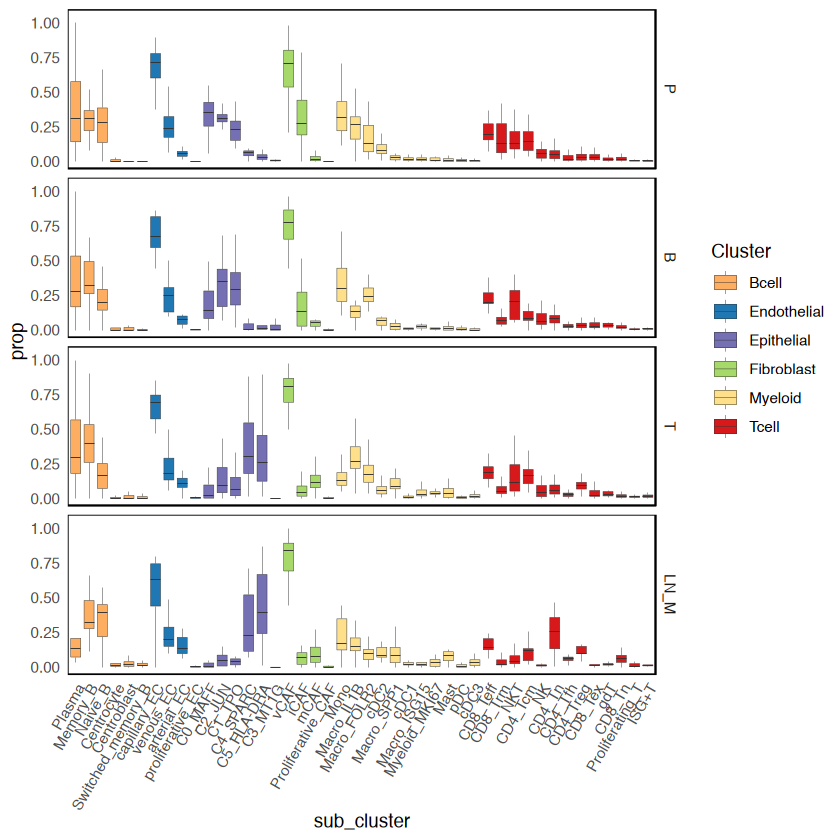

In [6]:
a

`summarise()` has grouped output by 'Tissue_desc', 'sub_cluster', 'Cluster'.
You can override using the `.groups` argument.


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


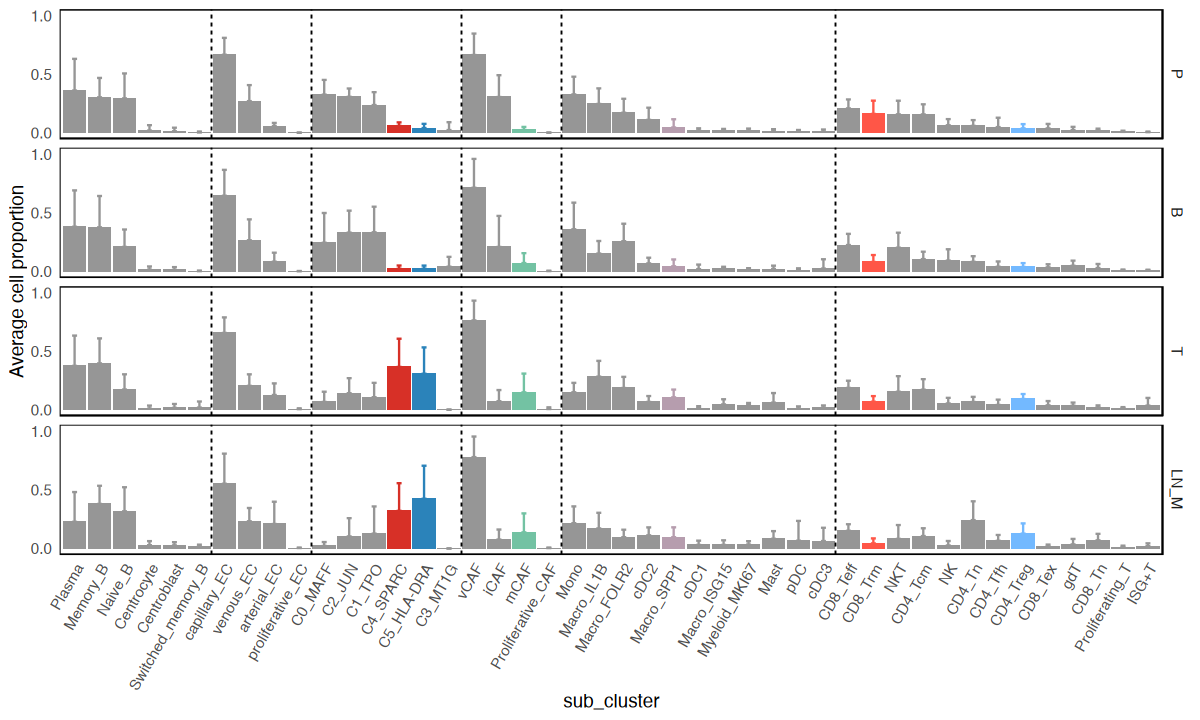

In [7]:
sample_cell_prop$fill_group = sample_cell_prop$sub_cluster

show_sub_cluster = c('CD8_Trm',# 'cDC2',#'Macro_IL1B','γδT', # B
                     'C4_SPARC','C5_HLA-DRA',  # Epi
                     #'iCAF', 
                     'mCAF', # fibroblast
                     #'proliferative_EC','Myeloid_MKI67',#'Proliferating T', # proliferate
                     'Macro_SPP1','CD4_Treg'
                     )
sample_cell_prop$fill_group = sample_cell_prop$sub_cluster
sample_cell_prop[!sample_cell_prop$sub_cluster%in%show_sub_cluster,'fill_group'] = 'NS'

a=sample_cell_prop %>%
  filter(Tissue_desc!='LN_N') %>%
  filter(sub_cluster!='LEC') %>%
  group_by(Tissue_desc,sub_cluster,Cluster,fill_group) %>%
  summarise(mean_prop=mean(prop), sd=sd(prop)) %>%
  mutate(Tissue_desc = factor(Tissue_desc, c('P','B','T','LN_M'))) %>%
  mutate(sub_cluster = factor(sub_cluster, celltype_order$sub_cluster)) %>%
  ggplot(aes(x=sub_cluster, y=mean_prop, fill=fill_group)) +
  geom_errorbar(aes(ymin = mean_prop, ymax = mean_prop + sd, color=fill_group), width = 0.2) +
  geom_bar(stat = 'identity',width = 0.9)+
  geom_vline(xintercept = c(6.5,10.5,16.5,20.5,31.5), size=0.4, linetype='dashed', color='black')+
  #geom_jitter(width = 0.2, size=1, shape=21,stroke=0.1)+
  scale_fill_manual(values = c('NS'='#969696','Yes'='red',all_subtype_colors))+
  scale_color_manual(values = c('NS'='#969696','Yes'='red',all_subtype_colors))+
  facet_wrap(~Tissue_desc, ncol=1,strip.position = 'right')+
  #facet_grid(Tissue_desc~Cluster,  scales = 'free_x')+
  scale_y_continuous(expand = expansion(mult = c(0.05,.1)), breaks = c(0,0.5,1))+
  #scale_x_discrete(position = 'top')+
  theme_minimal()+
    labs(y='Average cell proportion')+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank(),
        axis.text.x = element_text(angle=60, hjust=1,vjust=1))+
  NoLegend()
options(repr.plot.width=10, repr.plot.height=6)
a

In [107]:
ggsave(glue('{output_dir}/inter_tissue_cell_proportiondistribution.pdf'), a,
       width=180, height=120, units='mm', dpi = 450, bg = 'transparent')

Warning message in wilcox.test.default(c(0.05765595463138, 0.0555555555555556, 0.0879765395894428, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.05765595463138, 0.0555555555555556, 0.0879765395894428, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.195, 0.139784946236559, 0.0807453416149068, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.505747126436782, 0.450356555128908, 0.386583011583012, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.505747126436782, 0.450356555128908, 0.386583011583012, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0, 0.125966850828729, 0.0762759394279305, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00201207243460765, 0.0148058252427184, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.1589537

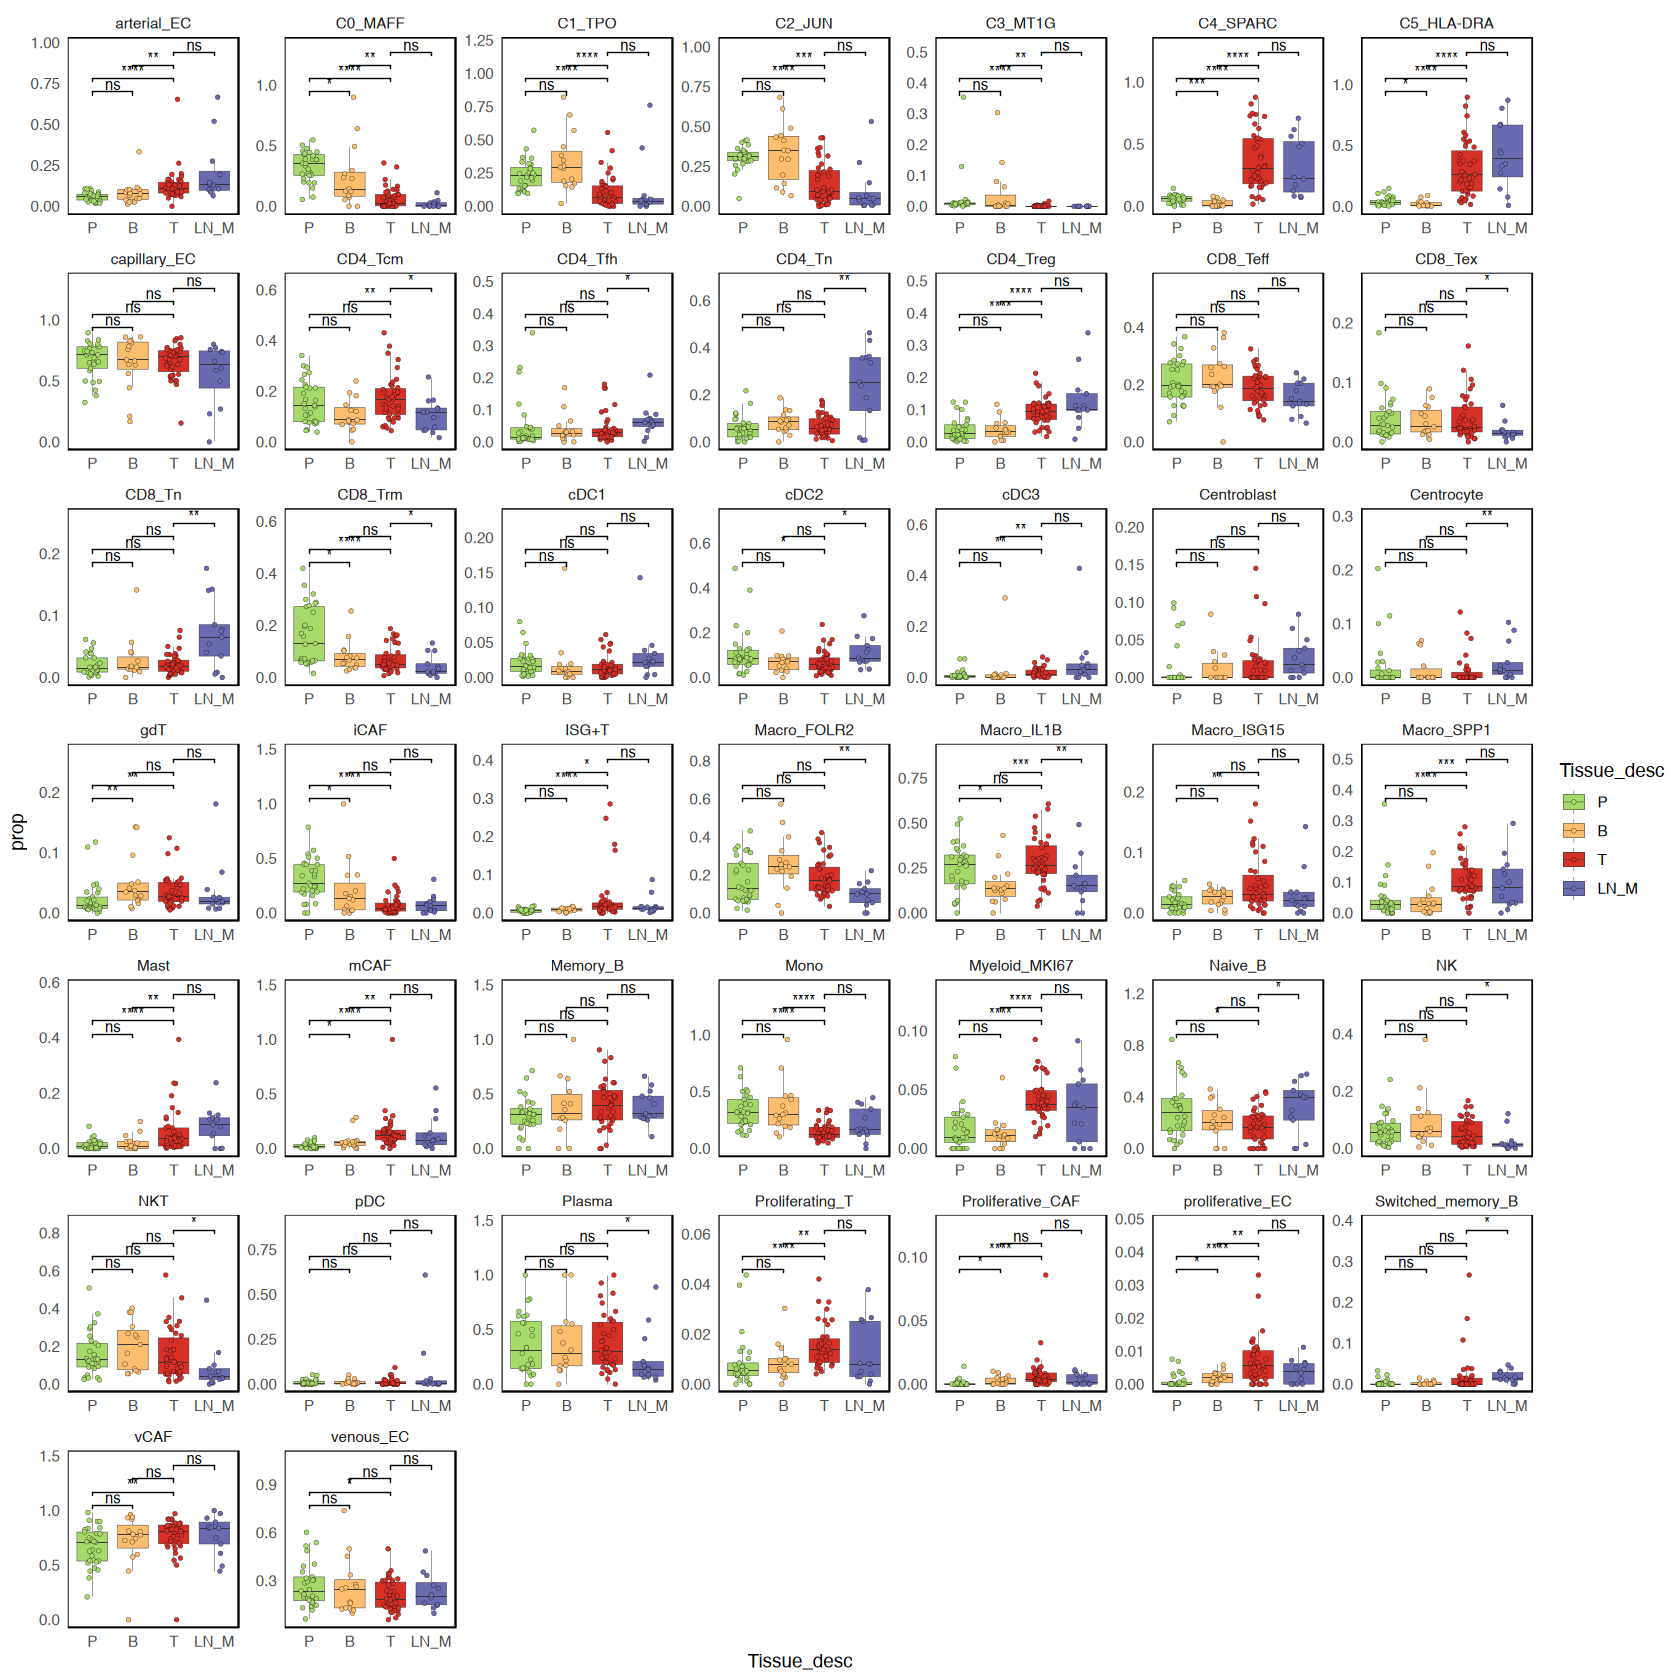

In [9]:
sample_cell_prop2 = sample_cell_prop
# sample_cell_prop2$Tissue_desc[sample_cell_prop2$Tissue_desc=='P'] = 'N'
a=sample_cell_prop2 %>%
  filter(Tissue_desc!='LN_N') %>%
  #filter(Tissue_desc!='LN_M') %>%
  filter(sub_cluster!='LEC') %>%
  #filter(sub_cluster%in%show_sub_cluster) %>%
  #mutate(sub_cluster = factor(sub_cluster, show_sub_cluster)) %>%
  mutate(Tissue_desc = factor(Tissue_desc, c('P','B','T','LN_M'))) %>%
  ggplot(aes(x=Tissue_desc, y=prop, fill=Tissue_desc)) +
  geom_boxplot(outlier.shape=NA, size=0.1)+
  geom_jitter(width = 0.2, size=1, shape=21,stroke=0.1)+
  #geom_point(aes(fill=Tissue_desc),size=2, shape=21, color='black', alpha=1) +
  #scale_fill_igv()+
  scale_fill_manual(values = tissue_colors)+
  stat_compare_means(comparisons = list(c('P','B'),
                                        c('P','T'),
                                        c('B','T'),
                                        c('T','LN_M')
  ), label = 'p.signif', size=3)+
  facet_wrap(~sub_cluster, nrow=7, scales = 'free')+
  scale_y_continuous(expand = expansion(mult = c(0.05,.1)))+
  theme_minimal()+

  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank())
options(repr.plot.width=14, repr.plot.height=14)
a

In [110]:
ggsave(glue('{output_dir}/inter_tissue_cell_proportiondistributionboxplot_all.pdf'), a,
       width=14, height=14, units='in', dpi = 450, bg = 'transparent')

Warning message in wilcox.test.default(c(0.05765595463138, 0.0555555555555556, 0.0879765395894428, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.05765595463138, 0.0555555555555556, 0.0879765395894428, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.195, 0.139784946236559, 0.0807453416149068, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.505747126436782, 0.450356555128908, 0.386583011583012, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.505747126436782, 0.450356555128908, 0.386583011583012, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0, 0.125966850828729, 0.0762759394279305, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00201207243460765, 0.0148058252427184, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.1589537

In [13]:
tissue_colors <- c(
  "P" = "#A6D96A",
  "N" = "#A6D96A",
  "B" = "#FDBF6F",
  "T" = "#D73027",  
  "LN_N" = "#C4C2E0",
  "LN_M" = "#6A6AB1",
  'LNM' = "#6A6AB1",
  "Non-metastasis" = "#A6D96A",
  "LN metastasis" = "#F7E2A5",
  "Distant metastasis" = "#6A3D9A"
)

Warning message in wilcox.test.default(c(0.0541187739463602, 0.0905101481075151, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0541187739463602, 0.0905101481075151, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0, 0.0707182320441989, 0.0504767246214246, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0210727969348659, 0.031815688425672, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0144927536231884, 0.0357142857142857, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0282485875706215, 0.004149377593361, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0282485875706215, 0.004149377593361, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.285714285714286, 0, 0.0076530612244898, :
“cannot compute exact p-value with ties”
War

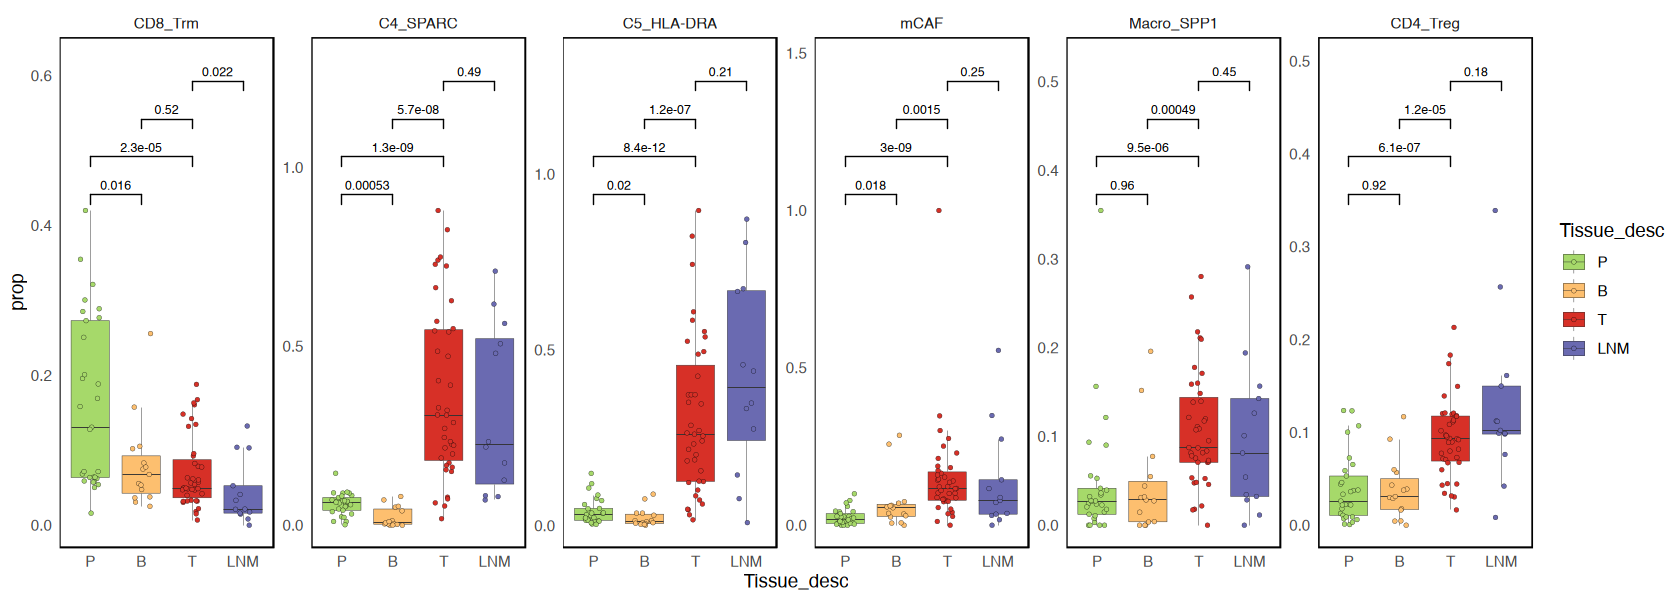

In [14]:
sample_cell_prop2 = sample_cell_prop
sample_cell_prop2$Tissue_desc[sample_cell_prop2$Tissue_desc=='LN_M'] = 'LNM'
a=sample_cell_prop2 %>%
  filter(Tissue_desc!='LN_N') %>%
  #filter(Tissue_desc!='LN_M') %>%
  filter(sub_cluster!='LEC') %>%
  filter(sub_cluster%in%show_sub_cluster) %>%
  mutate(sub_cluster = factor(sub_cluster, show_sub_cluster)) %>%
  mutate(Tissue_desc = factor(Tissue_desc, c('P','B','T','LNM'))) %>%
  ggplot(aes(x=Tissue_desc, y=prop, fill=Tissue_desc)) +
  geom_boxplot(outlier.shape=NA, size=0.1)+
  geom_jitter(width = 0.2, size=1, shape=21,stroke=0.1)+
  #geom_point(aes(fill=Tissue_desc),size=2, shape=21, color='black', alpha=1) +
  #scale_fill_igv()+
  scale_fill_manual(values = tissue_colors)+
  stat_compare_means(comparisons = list(c('P','B'),
                                        c('P','T'),
                                        c('B','T'),
                                        c('T','LNM')
  ), label = 'p.format', size=2.5)+
  facet_wrap(~sub_cluster, nrow=1, scales = 'free')+
  scale_y_continuous(expand = expansion(mult = c(0.05,.1)))+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank())
options(repr.plot.width=14, repr.plot.height=5)
a

In [15]:
ggsave(glue('{output_dir}/inter_tissue_cell_proportiondistributionboxplot_signif.pdf'), a,
       width=260, height=60, units='mm', dpi = 450, bg = 'transparent')

Warning message in wilcox.test.default(c(0.0541187739463602, 0.0905101481075151, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0541187739463602, 0.0905101481075151, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0, 0, 0.0707182320441989, 0.0504767246214246, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0210727969348659, 0.031815688425672, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0144927536231884, 0.0357142857142857, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0282485875706215, 0.004149377593361, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.0282485875706215, 0.004149377593361, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.285714285714286, 0, 0.0076530612244898, :
“cannot compute exact p-value with ties”
War

`summarise()` has grouped output by 'Tissue_desc', 'sub_cluster'. You can
override using the `.groups` argument.


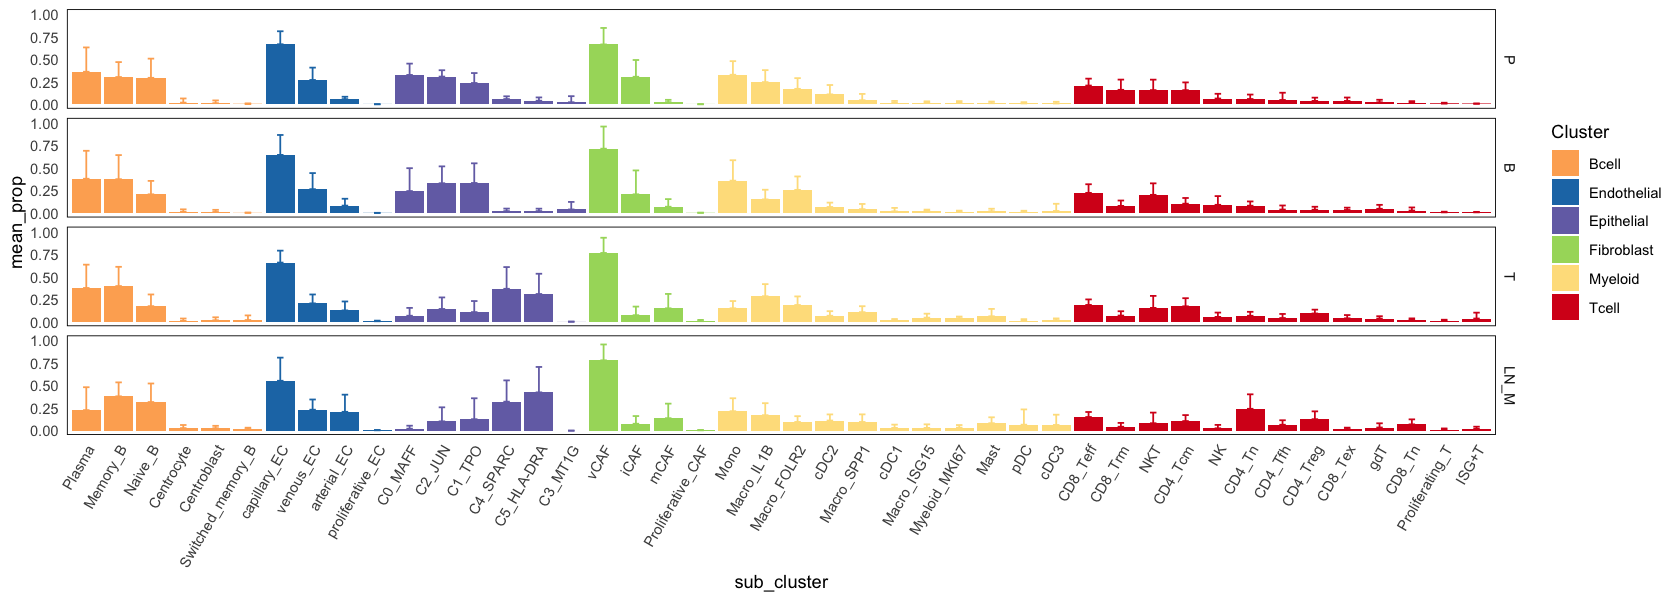

In [90]:
a=sample_cell_prop %>%
  filter(Tissue_desc!='LN_N') %>%
  filter(sub_cluster!='LEC') %>%
  group_by(Tissue_desc,sub_cluster,Cluster) %>%
  summarise(mean_prop=mean(prop), sd=sd(prop)) %>%
  mutate(Tissue_desc = factor(Tissue_desc, c('P','B','T','LN_M'))) %>%
  mutate(sub_cluster = factor(sub_cluster, celltype_order$sub_cluster)) %>%
  ggplot(aes(x=sub_cluster, y=mean_prop, fill=Cluster)) +
  geom_errorbar(aes(ymin = mean_prop, ymax = mean_prop + sd, color=Cluster), width = 0.2) +
  geom_bar(stat = 'identity')+
  #geom_jitter(width = 0.2, size=1, shape=21,stroke=0.1)+
  scale_fill_manual(values = Celltype_colors)+
  scale_color_manual(values = Celltype_colors)+
  #facet_grid(Tissue_desc~Cluster,scales = 'free_x')+
  facet_wrap(~Tissue_desc, ncol=1,strip.position = 'right')+
  scale_y_continuous(expand = expansion(mult = c(0.05,.1)))+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid = element_blank(),
        axis.text.x = element_text(angle=60, hjust=1,vjust=1))
a

`summarise()` has grouped output by 'Tissue_desc', 'Cluster'. You can override
using the `.groups` argument.


[1] "Tcell"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warni

[1] "Bcell"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warnin

[1] "Myeloid"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warnin

[1] "Endothelial"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warnin

[1] "Epithelial"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warni

[1] "Fibroblast"


`summarise()` has grouped output by 'orig.ident'. You can override using the
`.groups` argument.
Joining with `by = join_by(orig.ident)`
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_p):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_t, tmp_b):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_LN, tmp_t):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(tmp_b, tmp_p):
“cannot compute exact p-value with ties”
Warnin

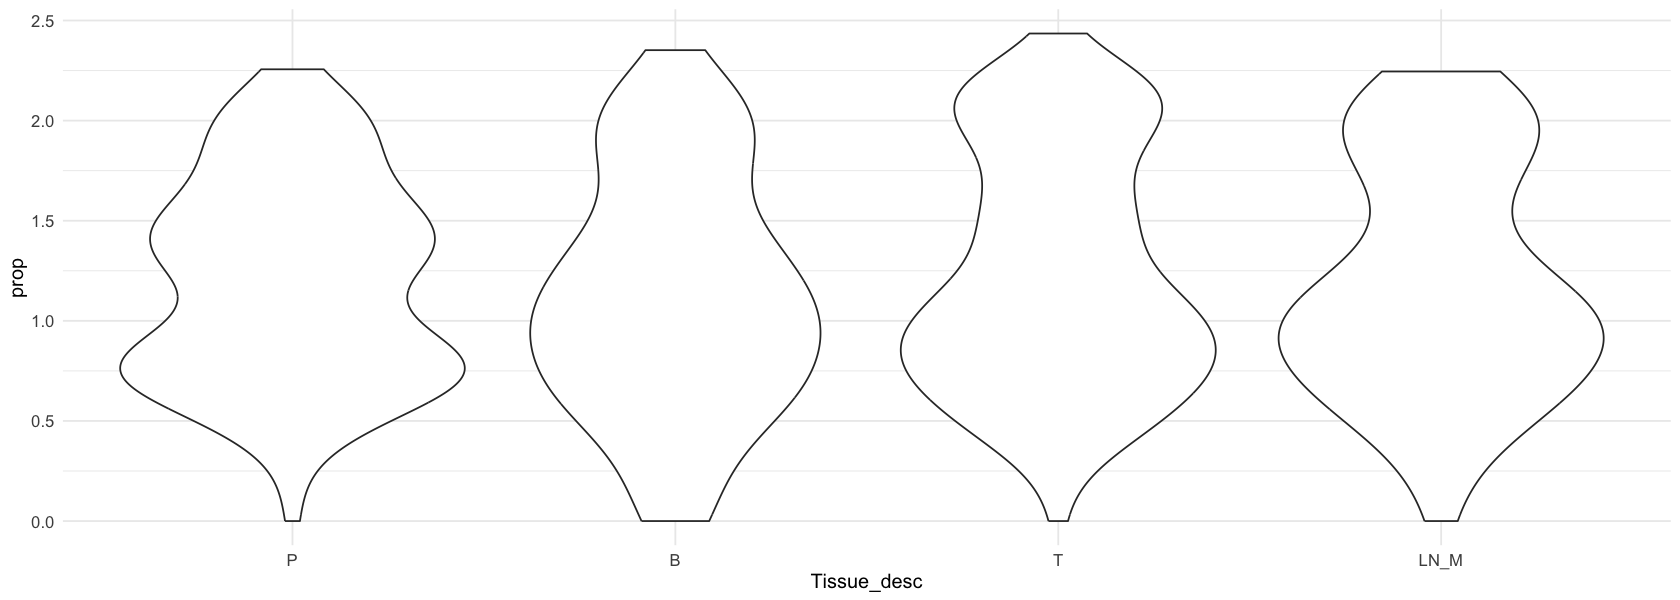

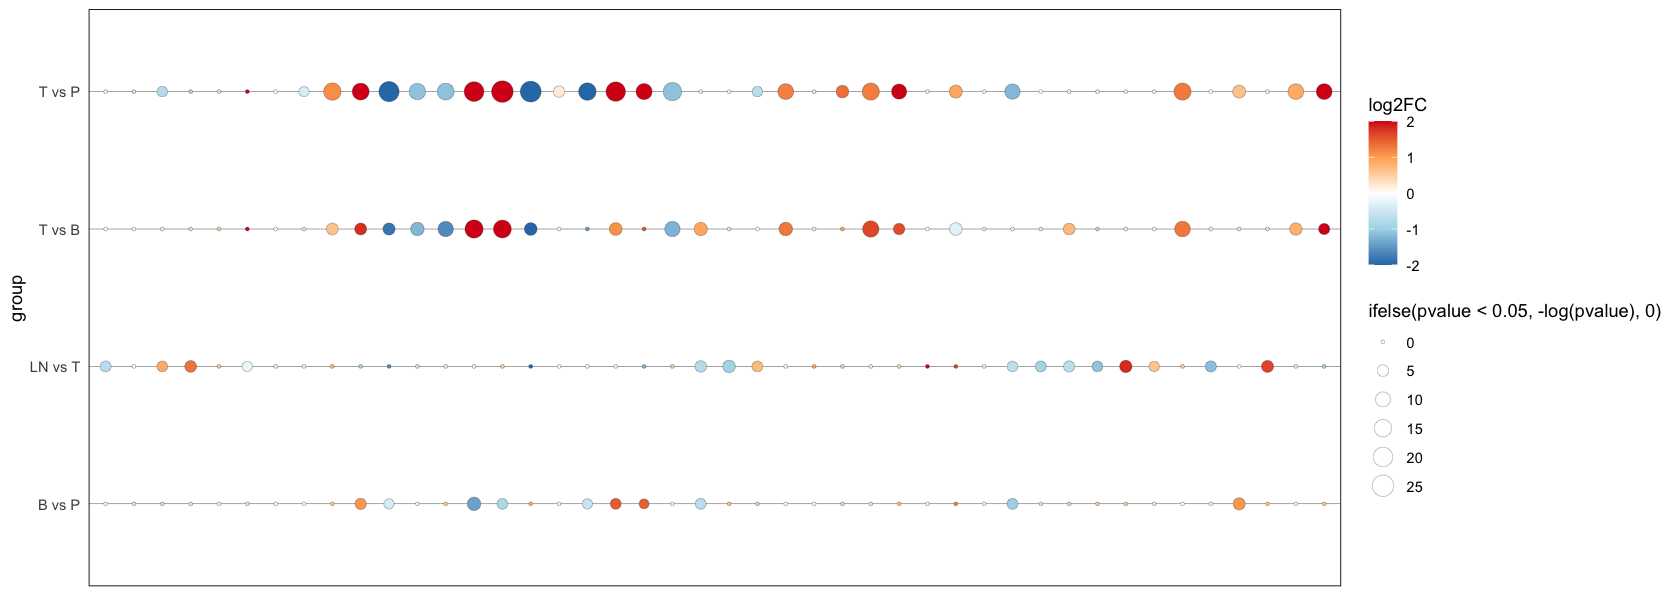

In [91]:
sample_cell_prop %>%
  filter(Tissue_desc!='LN_N') %>%
  filter(sub_cluster!='LEC') %>%
  group_by(Tissue_desc,Cluster,orig.ident)  %>%
  summarise(prop=diversity(prop)) %>%
  mutate(Tissue_desc = factor(Tissue_desc, c('P','B','T','LN_M'))) %>%
  ggplot(aes(x=Tissue_desc, y=prop))+
  geom_violin()



sample_cell_prop2 =  c()
for(cl in unique(tmp_meta$Cluster)[1:6]){
  print(cl)
  tmp_srt = tmp_meta[tmp_meta$Cluster==cl,]
  tmp_prop = my_level_prop(tmp_srt,levels='orig.ident', 
                           group_by_name='sub_cluster',
                           mutate_meta = c('Tissue_desc', 'patient'),
                           obj_is_meta = TRUE)
  for(sub_cl in unique(tmp_prop$sub_cluster)){
    tmp_b = tmp_prop[tmp_prop$Tissue_desc=='B'&tmp_prop$sub_cluster==sub_cl, 'prop']
    tmp_t = tmp_prop[tmp_prop$Tissue_desc=='T'&tmp_prop$sub_cluster==sub_cl, 'prop']
    tmp_p = tmp_prop[tmp_prop$Tissue_desc=='P'&tmp_prop$sub_cluster==sub_cl, 'prop']
    tmp_LN = tmp_prop[tmp_prop$Tissue_desc=='LN_M'&tmp_prop$sub_cluster==sub_cl, 'prop']
    # B vs P
    tt1 = wilcox.test(tmp_b,tmp_p)
    tt_bp = data.frame('Celltype'=cl,'sub_cluster'=sub_cl,'group'='B vs P','FC'=mean(tmp_b)/mean(tmp_p),'pvalue'=tt1$p.value)
    # T vs P
    tt1 = wilcox.test(tmp_t,tmp_p)
    tt_tp = data.frame('Celltype'=cl,'sub_cluster'=sub_cl,'group'='T vs P','FC'=mean(tmp_t)/mean(tmp_p),'pvalue'=tt1$p.value)
    # T vs B
    tt1 = wilcox.test(tmp_t,tmp_b)
    tt_tb = data.frame('Celltype'=cl,'sub_cluster'=sub_cl,'group'='T vs B','FC'=mean(tmp_t)/mean(tmp_b),'pvalue'=tt1$p.value)
    
    # LN vs T
    tt1 = wilcox.test(tmp_LN,tmp_t)
    tt_lnt = data.frame('Celltype'=cl,'sub_cluster'=sub_cl,'group'='LN vs T','FC'=mean(tmp_LN)/mean(tmp_t),'pvalue'=tt1$p.value)
    
    sample_cell_prop2 = rbind(sample_cell_prop2, tt_bp,tt_tp,tt_tb,tt_lnt)
  }
  
}
sample_cell_prop2$log2FC = log2(sample_cell_prop2$FC)
sample_cell_prop2$log2FC[sample_cell_prop2$log2FC>2] = 2
sample_cell_prop2$log2FC[sample_cell_prop2$log2FC<(-2)] = -2

b=sample_cell_prop2 %>%
  #filter(pvalue<0.05) %>%
  mutate(sub_cluster = factor(sub_cluster, celltype_order$sub_cluster)) %>%
  ggplot(aes(x=sub_cluster, y=group))+
  geom_point(aes(fill=log2FC, size = ifelse(pvalue<0.05,-log(pvalue),0)),shape=21, stroke = 0.1)+
  scale_fill_gradientn(colours = c('#2C7BB6','#ABD9E9','white','#FDAE61','#D7191C'))+
  theme_minimal()+
  theme(panel.border = element_rect(color='black', fill=NA),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(color='black', size=0.1),
        axis.text.x = element_blank(),
        #axis.text.x = element_text(angle=60, hjust=1,vjust=1),
        axis.title.x = element_blank()
        )
b
#cowplot::plot_grid(b,a,ncol=1, align = 'hv',rel_heights = c(0.2,1))
(b/a)+ patchwork::plot_layout(heights = c(0.2, 1))